<a href="https://colab.research.google.com/github/npnayak/Credit-Card/blob/main/IS833_Team_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit Card Approval Prediction

Our goal is to determine the ‘good’ or bad applicants. We will benchmark machine learning models on a challenging large-scale dataset to predict if an applicant is 'good' 
or 'bad' client. 

Source – Seanny - Machine Learning Group of ULB [Kaggle Link](https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction)

In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import RandomForestClassifier
from pandas.core.common import SettingWithCopyWarning
from pandas_profiling import ProfileReport
from pathlib import Path
from scipy.stats import probplot, chi2_contingency, chi2
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

from yellowbrick.model_selection import FeatureImportances
import scipy.stats as stats
import joblib
import os
%matplotlib inline

# **Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Save to df
cc_data_full_data = pd.read_csv("/content/drive/MyDrive/IS833 Team project/application_record.csv", encoding = 'utf-8')
credit_status = pd.read_csv("/content/drive/MyDrive/IS833 Team project/credit_record.csv", encoding = 'utf-8')

# Shape and preview
print('Application credit_status df shape:', cc_data_full_data.shape)
cc_data_full_data.head()

Application credit_status df shape: (438557, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [ ]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
# Shape and preview
print('Credit credit_status df shape:', credit_status.shape)
credit_status.head()

Credit credit_status df shape: (1048575, 3)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


# **Missing Values**

In [ ]:
cc_data_full_data.isna().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [ ]:
credit_status.isna().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

# **Duplicates**

In [ ]:
print(f'Duplicates in cc_data_full_data df: {cc_data_full_data.iloc[:,1:].duplicated().sum()}, ({np.round(100*cc_data_full_data.iloc[:,1:].duplicated().sum()/len(cc_data_full_data),1)}%)')
print('')
print(f'Duplicates in credit_status df: {credit_status.duplicated().sum()}, ({np.round(100*credit_status.duplicated().sum()/len(credit_status),1)}%)')

Duplicates in cc_data_full_data df: 348472, (79.5%)

Duplicates in credit_status df: 0, (0.0%)


In [ ]:
cc_data_full_data.nunique()

ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64

In [ ]:
credit_status.nunique()

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

In [ ]:
# Drop duplicates
cc_data_full_data=cc_data_full_data.drop_duplicates(subset=cc_data_full_data.columns[1:], keep='first')

In [ ]:
# Fill missing values
cc_data_full_data['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [ ]:
# Drop constant feature
cc_data_full_data.drop('FLAG_MOBIL', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
cc_data_full_data.nunique()

ID                     90085
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN              12
AMT_INCOME_TOTAL         866
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH             16379
DAYS_EMPLOYED           9406
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
OCCUPATION_TYPE           19
CNT_FAM_MEMBERS           13
dtype: int64

In [ ]:
print(f'Duplicates in cc_data_full_data df: {cc_data_full_data.iloc[:,1:].duplicated().sum()}, ({np.round(100*cc_data_full_data.iloc[:,1:].duplicated().sum()/len(cc_data_full_data),1)}%)')
print('')
print(f'Duplicates in credit_status df: {credit_status.duplicated().sum()}, ({np.round(100*credit_status.duplicated().sum()/len(credit_status),1)}%)')

Duplicates in cc_data_full_data df: 0, (0.0%)

Duplicates in credit_status df: 0, (0.0%)


# Creating the Target Variable

In [ ]:
begin_month=pd.DataFrame(credit_status.groupby(['ID'])['MONTHS_BALANCE'].agg(min))
begin_month=begin_month.rename(columns={'MONTHS_BALANCE':'Account age'})
cc_data_full_data=pd.merge(cc_data_full_data,begin_month,how='left',on='ID')
credit_status['dep_value'] = None
credit_status['dep_value'][credit_status['STATUS'] =='2']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='3']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='4']='Yes'
credit_status['dep_value'][credit_status['STATUS'] =='5']='Yes'
cpunt=credit_status.groupby('ID').count()
cpunt['dep_value'][cpunt['dep_value'] > 0]='Yes'
cpunt['dep_value'][cpunt['dep_value'] == 0]='No'
cpunt = cpunt[['dep_value']]
cc_data_full_data = pd.merge(cc_data_full_data,cpunt,how='inner',on='ID')
cc_data_full_data['Is high risk']=cc_data_full_data['dep_value']
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='Yes','Is high risk']=1
cc_data_full_data.loc[cc_data_full_data['Is high risk']=='No','Is high risk']=0
cc_data_full_data.drop('dep_value',axis=1,inplace=True)
warnings.simplefilter(action='always', category=SettingWithCopyWarning)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A va

# Rename Columns

In [ ]:
# rename the features to a more readable feature names
cc_data_full_data = cc_data_full_data.rename(columns={
    'CODE_GENDER':'Gender',
    'FLAG_OWN_CAR':'Has a car',
    'FLAG_OWN_REALTY':'Has a property',
    'CNT_CHILDREN':'Children count',
    'AMT_INCOME_TOTAL':'Income',
    'NAME_INCOME_TYPE':'Employment status',
    'NAME_EDUCATION_TYPE':'Education level',
    'NAME_FAMILY_STATUS':'Marital status',
    'NAME_HOUSING_TYPE':'Dwelling',
    'DAYS_BIRTH':'Age',
    'DAYS_EMPLOYED': 'Employment length',
    'FLAG_MOBIL': 'Has a mobile phone',
    'FLAG_WORK_PHONE': 'Has a work phone',
    'FLAG_PHONE': 'Has a phone',
    'FLAG_EMAIL': 'Has an email',
    'OCCUPATION_TYPE': 'Job title',
    'CNT_FAM_MEMBERS': 'Family member count',
    'Account age': 'Account age'
    })

In [ ]:
cc_data_full_data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9709 entries, 0 to 9708
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9709 non-null   int64  
 1   Gender               9709 non-null   object 
 2   Has a car            9709 non-null   object 
 3   Has a property       9709 non-null   object 
 4   Children count       9709 non-null   int64  
 5   Income               9709 non-null   float64
 6   Employment status    9709 non-null   object 
 7   Education level      9709 non-null   object 
 8   Marital status       9709 non-null   object 
 9   Dwelling             9709 non-null   object 
 10  Age                  9709 non-null   int64  
 11  Employment length    9709 non-null   int64  
 12  Has a work phone     9709 non-null   int64  
 13  Has a phone          9709 non-null   int64  
 14  Has an email         9709 non-null   int64  
 15  Job title            9709 non-null   o

In [ ]:
cc_data_full_data.head()

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,Other,2.0,-15.0,0
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,-29.0,0
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,-4.0,0
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,Other,1.0,-20.0,0
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,Accountants,2.0,-5.0,0


# Split the data into training and test sets, creating a copy of the datasets

In [ ]:
# split the data into train and test
def data_split(df, test_size):
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42)
    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [ ]:
cc_train_original, cc_test_original = data_split(cc_data_full_data, 0.2)

In [ ]:
cc_train_original.shape

(7767, 19)

In [ ]:
cc_test_original.shape

(1942, 19)

In [ ]:
# creating a copy of the dataset so that the original stays untouched
cc_train_copy = cc_train_original.copy()
cc_test_copy = cc_test_original.copy()

# Explore the Data

In [ ]:
cc_data_full_data.head()

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,0,0,Other,2.0,-15.0,0
1,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,0,0,0,Security staff,2.0,-29.0,0
2,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,0,1,1,Sales staff,1.0,-4.0,0
3,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,0,0,0,Other,1.0,-20.0,0
4,5008815,M,Y,Y,0,270000.0,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,Accountants,2.0,-5.0,0


In [ ]:
cc_data_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9709 entries, 0 to 9708
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   9709 non-null   int64  
 1   Gender               9709 non-null   object 
 2   Has a car            9709 non-null   object 
 3   Has a property       9709 non-null   object 
 4   Children count       9709 non-null   int64  
 5   Income               9709 non-null   float64
 6   Employment status    9709 non-null   object 
 7   Education level      9709 non-null   object 
 8   Marital status       9709 non-null   object 
 9   Dwelling             9709 non-null   object 
 10  Age                  9709 non-null   int64  
 11  Employment length    9709 non-null   int64  
 12  Has a work phone     9709 non-null   int64  
 13  Has a phone          9709 non-null   int64  
 14  Has an email         9709 non-null   int64  
 15  Job title            9709 non-null   o

In [ ]:
cc_data_full_data.describe()

,ID,Children count,Income,Age,Employment length,Has a work phone,Has a phone,Has an email,Family member count,Account age
count,9.709000e+03,9709.000000,9.709000e+03,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000,9709.000000
mean,5.076105e+06,0.422804,1.812282e+05,-15991.811618,61732.846328,0.217427,0.287671,0.087548,2.182614,-27.270059
std,4.080270e+04,0.767019,9.927731e+04,4246.224468,139656.322958,0.412517,0.452700,0.282650,0.932918,16.648057
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,0.000000,0.000000,0.000000,1.000000,-60.000000
25%,5.036955e+06,0.000000,1.125000e+05,-19565.000000,-2995.000000,0.000000,0.000000,0.000000,2.000000,-41.000000
50%,5.069449e+06,0.000000,1.575000e+05,-15611.000000,-1374.000000,0.000000,0.000000,0.000000,2.000000,-26.000000
75%,5.112986e+06,1.000000,2.250000e+05,-12440.000000,-339.000000,0.000000,1.000000,0.000000,3.000000,-13.000000
max,5.150479e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.000000,1.000000,1.000000,20.000000,0.000000


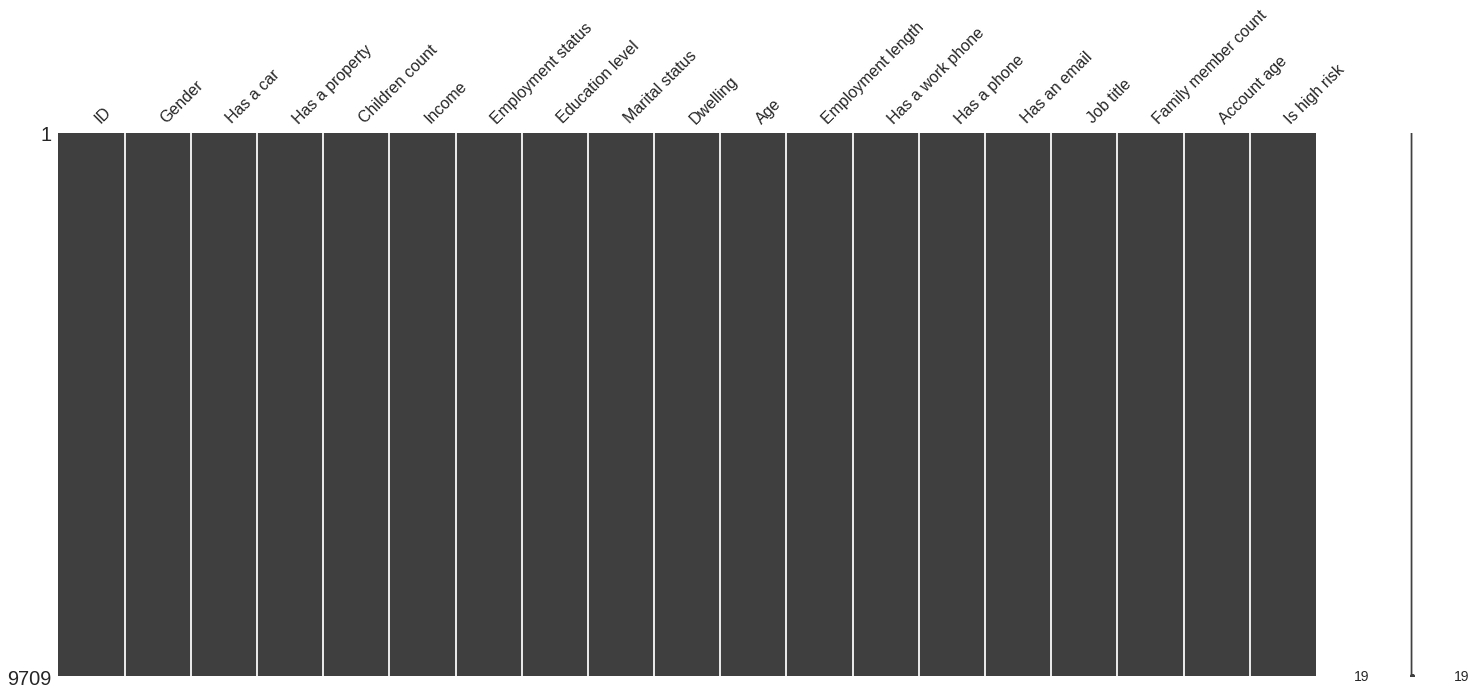

In [ ]:
msno.matrix(cc_data_full_data)
plt.show()

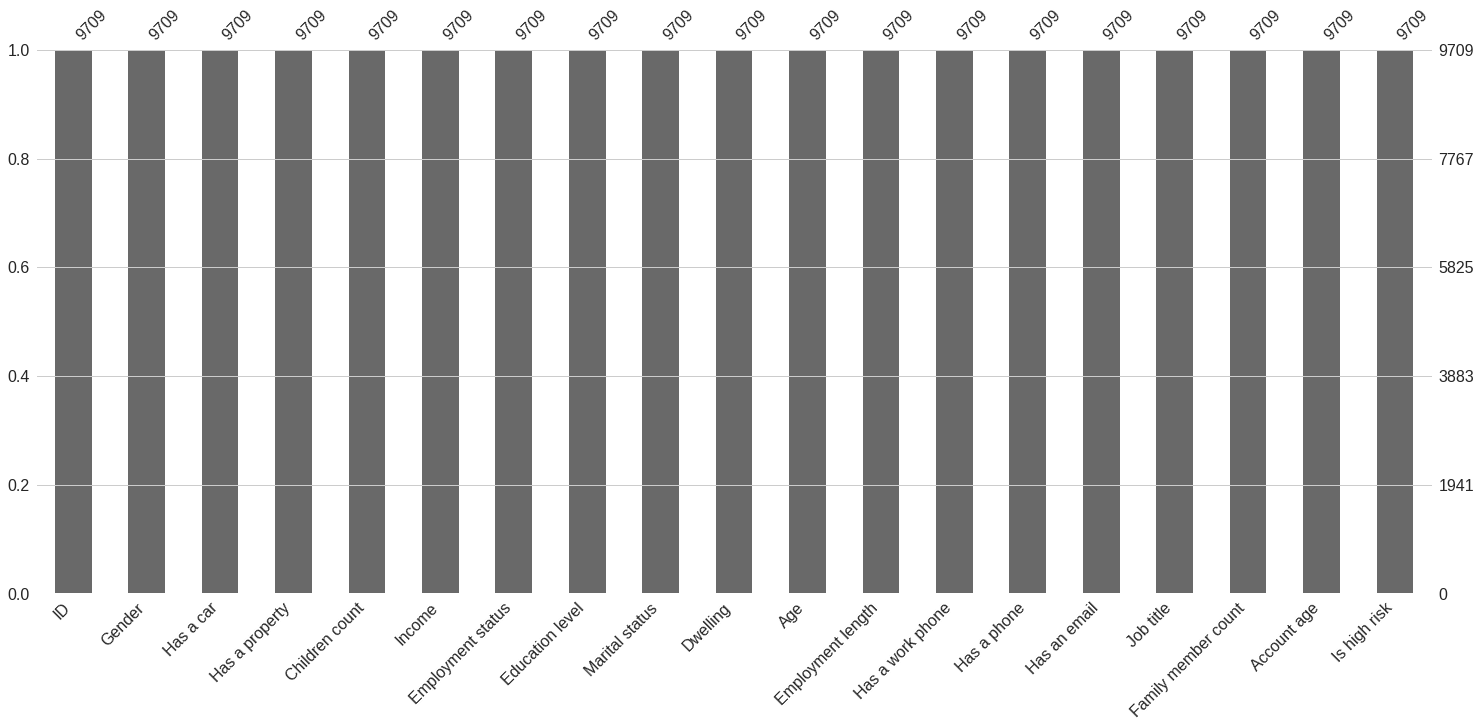

In [ ]:
msno.bar(cc_data_full_data)
plt.show()

# Functions used to explore each feature

In [ ]:
#Function that will return the value count and frequency of each observation within a feature
def value_cnt_norm_cal(df,feature):
    ftr_value_cnt = df[feature].value_counts()
    ftr_value_cnt_norm = df[feature].value_counts(normalize=True) * 100
    ftr_value_cnt_concat = pd.concat([ftr_value_cnt, ftr_value_cnt_norm], axis=1)
    ftr_value_cnt_concat.columns = ['Count', 'Frequency (%)']
    return ftr_value_cnt_concat

In [ ]:
# function to create display general information about the feature
def gen_info_feat(df,feature):
    if feature == 'Age':
        # change the feature to be express in positive numbers days
        print('Description:\n{}'.format((np.abs(df[feature])/365.25).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    elif feature == 'Employment length':
        # select only the rows where the rows are negative to ignore whose who have retired or unemployed
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        print('Description:\n{}'.format((employment_len_no_ret_yrs).describe()))
        print('*'*50)
        print('Object type:{}'.format(employment_len_no_ret.dtype))
    elif feature ==  'Account age':
        # change the account age to a positive number of months
        print('Description:\n{}'.format((np.abs(df[feature])).describe()))
        print('*'*50)
        print('Object type:{}'.format(df[feature].dtype))
    else:
        print('Description:\n{}'.format(df[feature].describe()))
        print('*'*50)
        print('Object type:\n{}'.format(df[feature].dtype))
        print('*'*50)
        value_cnt = value_cnt_norm_cal(df,feature)
        print('Value count:\n{}'.format(value_cnt))

In [ ]:
# function to create a pie chart plot
def create_pie_plot(df,feature):
    if feature ==  'Dwelling' or 'Education level':
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(10,10))
        # %1.2f%% display decimals in the pie chart with 2 decimal places
        plt.pie(ratio_list, startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best',labels=ratio_size.index)
        plt.axis('equal')
        return plt.show()
    else :
        ratio_size = value_cnt_norm_cal(df, feature)
        ratio_size_len = len(ratio_size.index)
        ratio_list = []
        for i in range(ratio_size_len):
            ratio_list.append(ratio_size.iloc[i]['Frequency (%)'])
        fig, ax = plt.subplots(figsize=(10,10))
        # %1.2f%% display decimals in the pie chart with 2 decimal places
        plt.pie(ratio_list, labels=ratio_size.index, autopct='%1.2f%%', startangle=90, wedgeprops={'edgecolor' :'black'})
        plt.title('Pie chart of {}'.format(feature))
        plt.legend(loc='best')
        plt.axis('equal')
        return plt.show()

In [ ]:
# function to create a bar chart plot
def create_bar_plot(df,feature):
    if feature == 'Marital status' or 'Dwelling' or 'Job title' or 'Employment status' or 'Education level':
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        ax.set_xticklabels(labels=value_cnt_norm_cal(df,feature).index,rotation=45,ha='right')
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()
    else :
        fig, ax = plt.subplots(figsize=(6,10))
        sns.barplot(x=value_cnt_norm_cal(df,feature).index,y=value_cnt_norm_cal(df,feature).values[:,0])
        plt.xlabel('{}'.format(feature))
        plt.ylabel('Count')
        plt.title('{} count'.format(feature))
        return plt.show()

In [ ]:
# function to create a box plot
def create_box_plot(df,feature):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(2,8))
        # change the feature to be express in positive numbers days
        sns.boxplot(y=np.abs(df[feature])/365.25)
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    elif feature == 'Children count':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,df[feature].max(),1))
        return plt.show()
    elif feature ==  'Employment length':
        fig, ax = plt.subplots(figsize=(2,8))
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        # employement length in days is a negative number so we need to change it to positive and change it to days
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        sns.boxplot(y=employment_len_no_ret_yrs)
        plt.title('{} distribution(Boxplot)'.format(feature))
        plt.yticks(np.arange(0,employment_len_no_ret_yrs.max(),2))
        return plt.show()
    elif feature ==  'Income':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        # suppress scientific notation
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        return plt.show()
    elif feature ==  'Account age':
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=np.abs(df[feature]))
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()
    else :
        fig, ax = plt.subplots(figsize=(2,8))
        sns.boxplot(y=df[feature])
        plt.title('{} distribution(Boxplot)'.format(feature))
        return plt.show()

In [ ]:
# function to create a histogram plot
def create_hist_plot(df,feature, the_bins=50):
    if feature == 'Age':
        fig, ax = plt.subplots(figsize=(18,10))
        # change the feature to be express in positive numbers days
        sns.histplot(np.abs(df[feature])/365.25,bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    elif feature == 'Income':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=the_bins,kde=True)
        # suppress scientific notation
        ax.get_xaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('{} distribution'.format(feature))
        return plt.show()
    elif feature ==  'Employment length':
        employment_len_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] < 0]
        # change the feature to be express in positive numbers days
        employment_len_no_ret_yrs = np.abs(employment_len_no_ret)/365.25
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(employment_len_no_ret_yrs,bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    elif feature ==  'Account age':
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(np.abs(df[feature]),bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()
    else :
        fig, ax = plt.subplots(figsize=(18,10))
        sns.histplot(df[feature],bins=the_bins,kde=True)
        plt.title('{} distribution'.format(feature))
        return plt.show()

In [ ]:
# High risk vs low risk applicants compared on a box plot
def low_high_risk_box_plot(df,feature):
    if feature == 'Age':
        print(np.abs(df.groupby('Is high risk')[feature].mean()/365.25))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature])/365.25,x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by age')
        return plt.show()
    elif feature == 'Income':
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        # suppress scientific notation
        ax.get_yaxis().set_major_formatter(
            matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()
    elif feature == 'Employment length':
        #checking is an applicant is high risk or not (for those who have negative employment length aka the employed ones)
        employment_no_ret = cc_train_copy['Employment length'][cc_train_copy['Employment length'] <0]
        employment_no_ret_idx = employment_no_ret.index
        employment_len_no_ret_yrs = np.abs(employment_no_ret)/365.25
        employment_no_ret_df = cc_train_copy.iloc[employment_no_ret_idx][['Employment length','Is high risk']]
        employment_no_ret_is_high_risk = employment_no_ret_df.groupby('Is high risk')['Employment length'].mean()
        # compare the age of high risk individuals with the age of low risk individuals (those who are employed)
        print(np.abs(employment_no_ret_is_high_risk)/365.25)
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=employment_len_no_ret_yrs,x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High vs low risk individuals grouped by {}'.format(feature))
        return plt.show()
    else :
        print(np.abs(df.groupby('Is high risk')[feature].mean()))
        fig, ax = plt.subplots(figsize=(5,8))
        sns.boxplot(y=np.abs(df[feature]),x=df['Is high risk'])
        plt.xticks(ticks=[0,1],labels=['no','yes'])
        plt.title('High risk individuals grouped by {}'.format(feature))
        return plt.show()

In [ ]:
# High risk vs low risk applicants compared on a bar plot
def low_high_risk_bar_plot(df,feature):
    is_high_risk_grp = df.groupby(feature)['Is high risk'].sum()
    is_high_risk_grp_srt = is_high_risk_grp.sort_values(ascending=False)
    print(dict(is_high_risk_grp_srt))
    fig, ax = plt.subplots(figsize=(6,10))
    sns.barplot(x=is_high_risk_grp_srt.index,y=is_high_risk_grp_srt.values)
    ax.set_xticklabels(labels=is_high_risk_grp_srt.index,rotation=45, ha='right')
    plt.ylabel('Count')
    plt.title('High risk applicants count grouped by {}'.format(feature))
    return plt.show()

In [ ]:
cc_train_copy.shape

(7767, 19)

# Univariate analysis

# ***Gender***

In [ ]:
gen_info_feat(cc_train_copy,'Gender')

Description:
count     7767
unique       2
top          F
freq      5029
Name: Gender, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
F   5029      64.748294
M   2738      35.251706


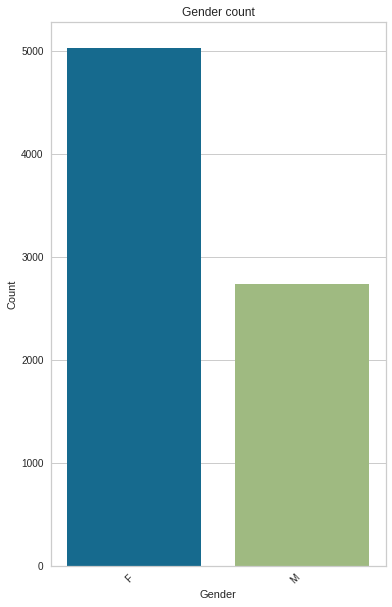

In [ ]:
create_bar_plot(cc_train_copy,'Gender')

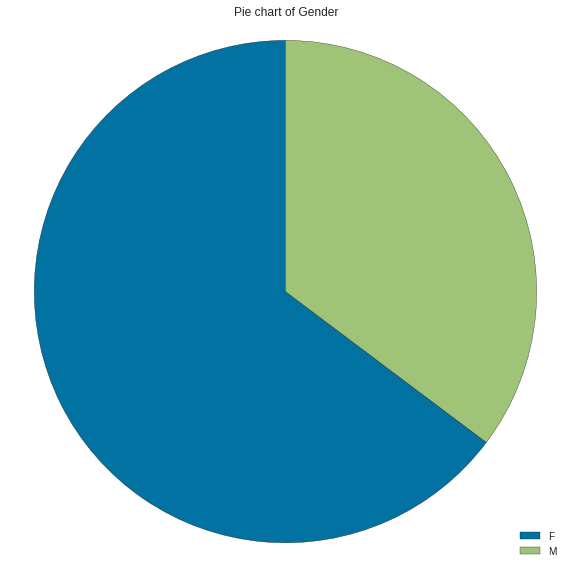

In [ ]:
create_pie_plot(cc_train_copy,'Gender')

Interpretation:

We have more female applicants than male (65% vs 35%)

# *Age*

In [ ]:
gen_info_feat(cc_train_copy,'Age')

Description:
count    7767.000000
mean       43.822532
std        11.593486
min        21.095140
25%        34.083504
50%        42.787132
75%        53.564682
max        68.862423
Name: Age, dtype: float64
**************************************************
Object type:int64


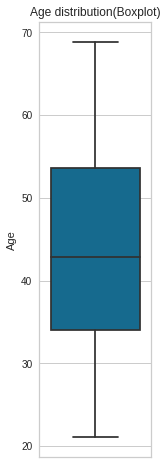

In [ ]:
create_box_plot(cc_train_copy,'Age')

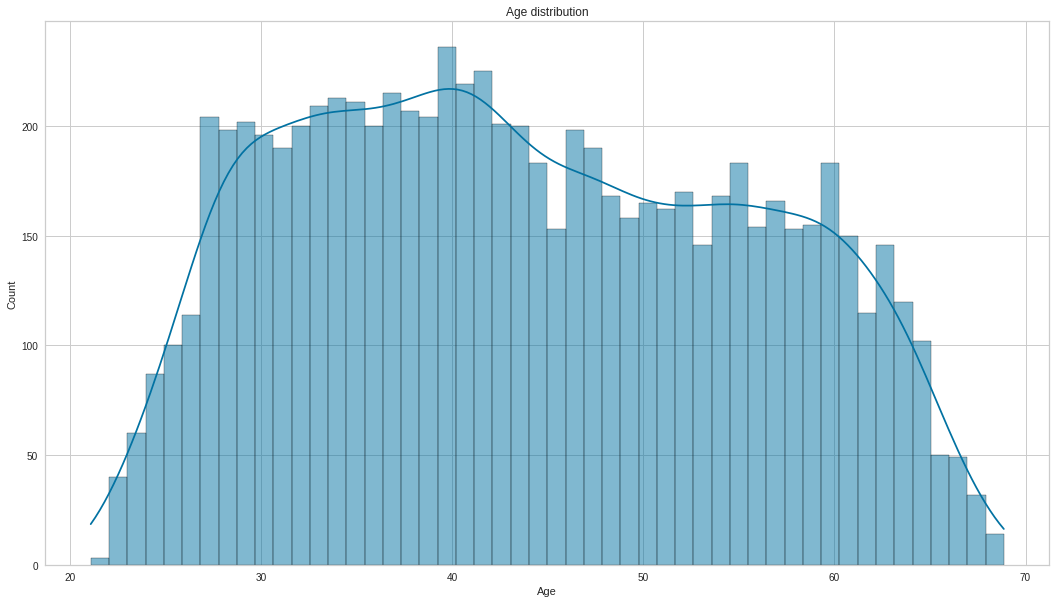

In [ ]:
create_hist_plot(cc_train_copy,'Age')


Is high risk
0    43.806830
1    44.559654
Name: Age, dtype: float64


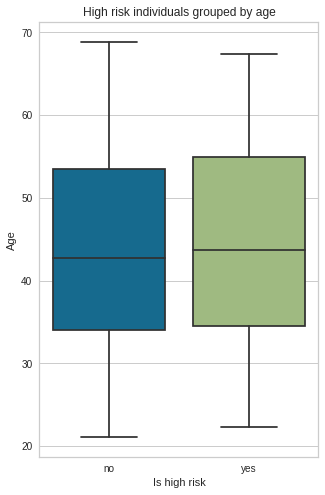

In [ ]:
low_high_risk_box_plot(cc_train_copy,'Age')

Interpretation:

The youngest applicant is 21 years old while the oldest is 69 years old. 

with the average of 44 and median of 43(outliers insensitive)

Age feature is not normally distributed, it is slightly positively skew

There is no difference between the average age of high and low risk applicants

# *Marital Status*

In [ ]:
gen_info_feat(cc_train_copy,'Marital status')

Description:
count        7767
unique          5
top       Married
freq         5227
Name: Marital status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Married                5227      67.297541
Single / not married   1088      14.007982
Civil marriage          666       8.574739
Separated               457       5.883868
Widow                   329       4.235870


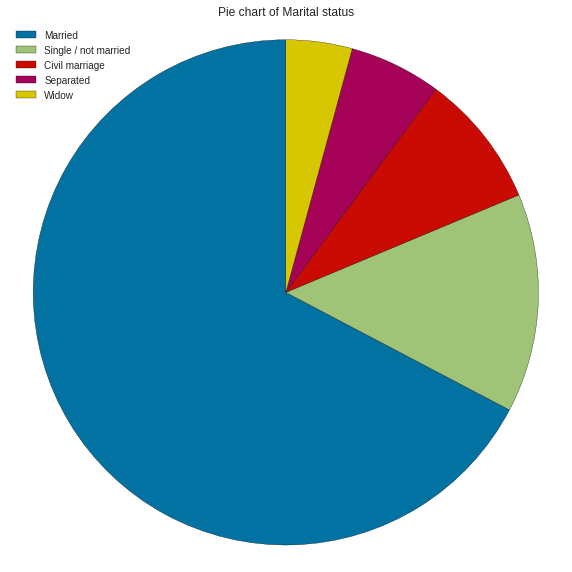

In [ ]:
create_pie_plot(cc_train_copy,'Marital status')

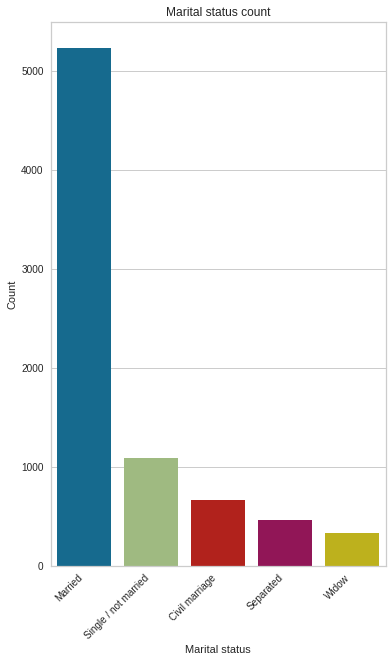

In [ ]:
create_bar_plot(cc_train_copy,'Marital status')

{'Married': 90, 'Single / not married': 45, 'Civil marriage': 10, 'Widow': 10, 'Separated': 7}


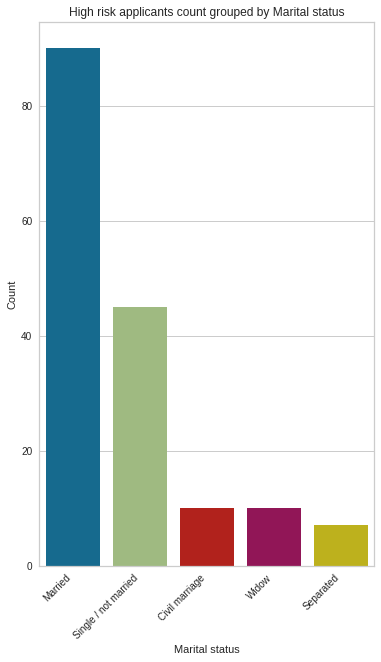

In [ ]:
low_high_risk_bar_plot(cc_train_copy,'Marital status')

Most applicants are married

Even though we have a higher number of applicants who are separated than those who are widow, it seems like widow applicants are high risk than those who are separated.

# ***Family Member Count***

In [ ]:
gen_info_feat(cc_train_copy,'Family member count')

Description:
count    7767.000000
mean        2.184241
std         0.942279
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        20.000000
Name: Family member count, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
      Count  Frequency (%)
2.0    4147      53.392558
1.0    1559      20.072100
3.0    1297      16.698854
4.0     650       8.368740
5.0      93       1.197374
6.0      14       0.180250
7.0       4       0.051500
15.0      1       0.012875
9.0       1       0.012875
20.0      1       0.012875


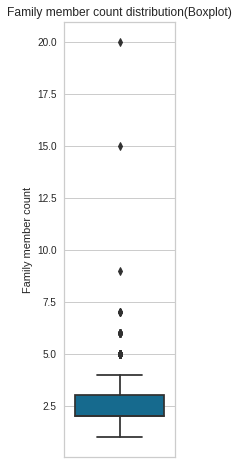

In [ ]:
create_box_plot(cc_train_copy,'Family member count')

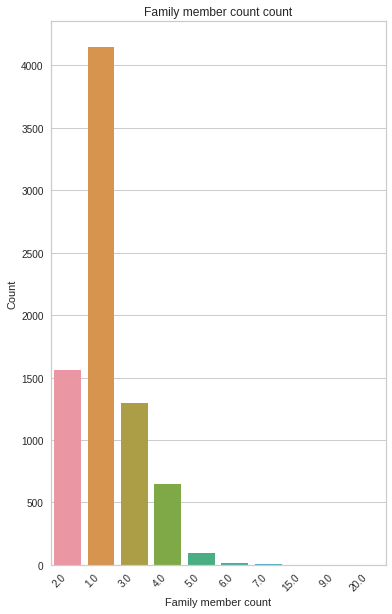

In [ ]:
create_bar_plot(cc_train_copy,'Family member count')

Interpretation:

Most applicants are two in their household, this is also confirmed with the fact that most don’t have a child (more on this in a bit)

We also have 6 outliers, 2 of them are extreme with 20 and 15 members in their household

# ***Children Count***

In [ ]:
gen_info_feat(cc_train_copy,'Children count')

Description:
count    7767.000000
mean        0.423716
std         0.778985
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        19.000000
Name: Children count, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
    Count  Frequency (%)
0    5466      70.374662
1    1488      19.157976
2     691       8.896614
3     100       1.287498
4      14       0.180250
5       5       0.064375
14      1       0.012875
7       1       0.012875
19      1       0.012875


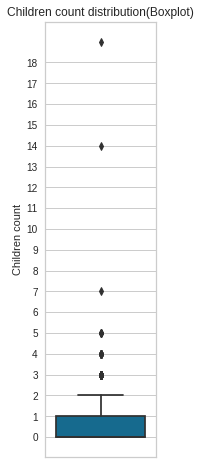

In [ ]:
create_box_plot(cc_train_copy,'Children count')

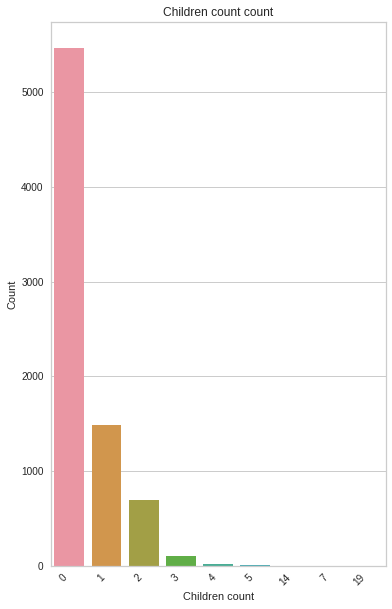

In [ ]:
create_bar_plot(cc_train_copy,'Children count')

Interpretation:

As previously discussed most applicant don’t have a child

Also here we have 6 outliers, probably the same from the family member count

# ***Dwelling***

In [ ]:
gen_info_feat(cc_train_copy,'Dwelling')

Description:
count                  7767
unique                    6
top       House / apartment
freq                   6939
Name: Dwelling, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                     Count  Frequency (%)
House / apartment     6939      89.339513
With parents           357       4.596369
Municipal apartment    271       3.489121
Rented apartment       113       1.454873
Office apartment        64       0.823999
Co-op apartment         23       0.296125


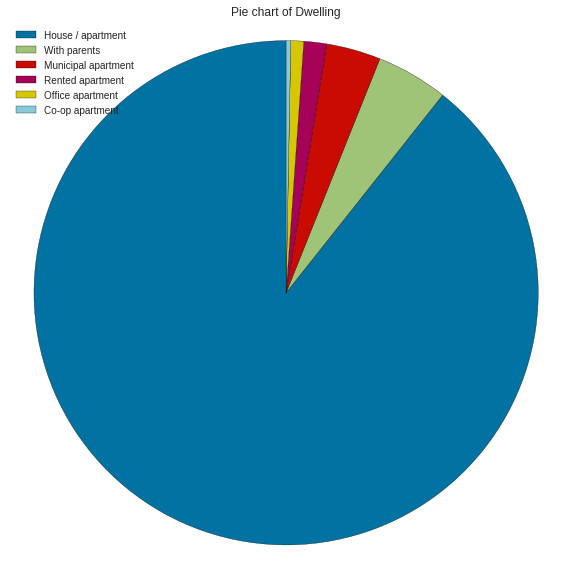

In [ ]:
create_pie_plot(cc_train_copy,'Dwelling')

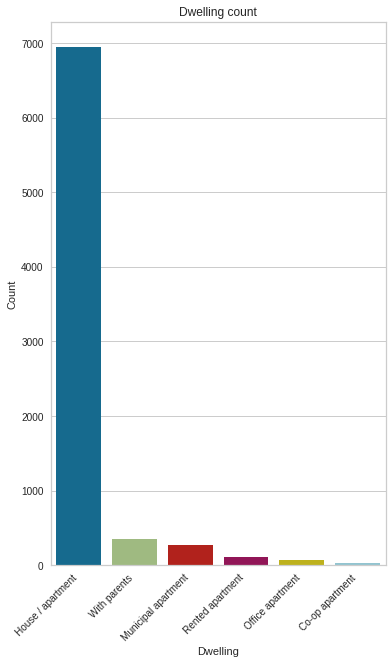

In [ ]:
create_bar_plot(cc_train_copy,'Dwelling')

Almost every applicants live in house or apartment

# ***Income***

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
gen_info_feat(cc_train_copy,'Income')

Description:
count      7767.00
mean     181047.38
std       98773.14
min       27000.00
25%      112500.00
50%      157500.00
75%      225000.00
max     1575000.00
Name: Income, dtype: float64
**************************************************
Object type:
float64
**************************************************
Value count:
           Count  Frequency (%)
135000.00    910          11.72
112500.00    679           8.74
180000.00    670           8.63
157500.00    654           8.42
225000.00    604           7.78
...          ...            ...
38700.00       1           0.01
133650.00      1           0.01
191250.00      1           0.01
145350.00      1           0.01
60376.50       1           0.01

[230 rows x 2 columns]


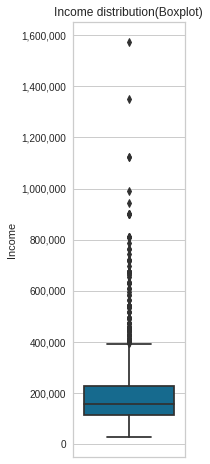

In [ ]:
create_box_plot(cc_train_copy,'Income')

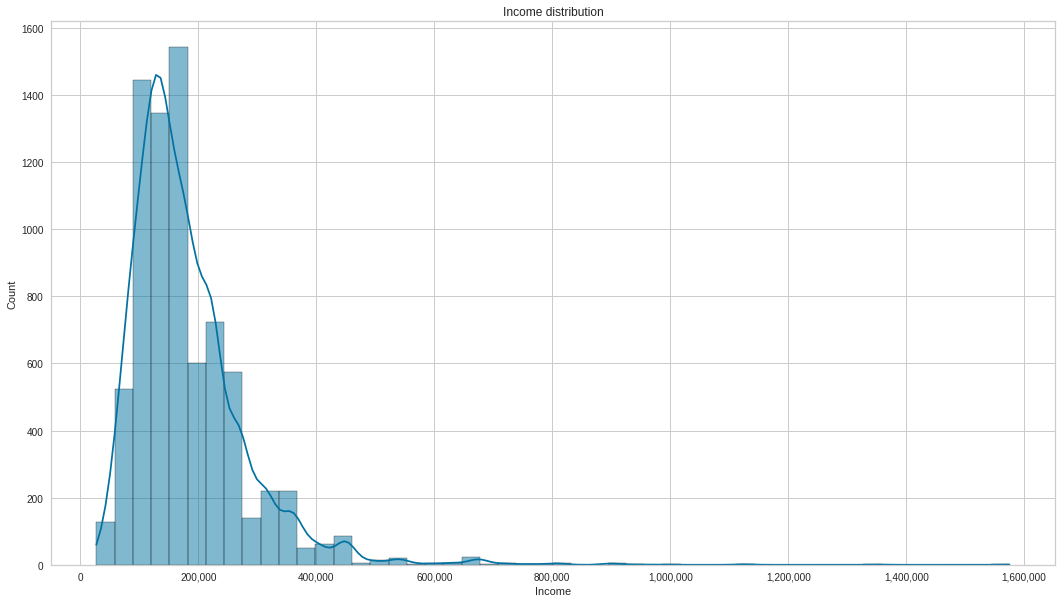

In [ ]:
create_hist_plot(cc_train_copy,'Income')

Is high risk
0   181058.16
1   180541.67
Name: Income, dtype: float64


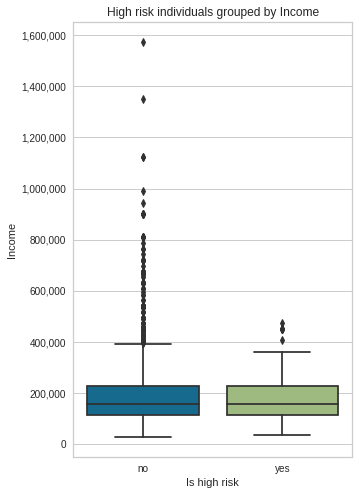

In [ ]:
low_high_risk_box_plot(cc_train_copy,'Income')

Interpretation:

The average income is 181407 but this amount accounts for outliers. If we ignore the outlier most people make 1575000

We have 3 applicants who makes more than 1000000

This feature is positively skewed

High risk and low risk applicants have roughly similar income

# ***Job Title***

In [ ]:
gen_info_feat(cc_train_copy,'Job title')

Description:
count      7767
unique       19
top       Other
freq       2383
Name: Job title, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                       Count  Frequency (%)
Other                   2383          30.68
Laborers                1379          17.75
Sales staff              767           9.88
Core staff               701           9.03
Managers                 632           8.14
Drivers                  506           6.51
High skill tech staff    301           3.88
Accountants              233           3.00
Medicine staff           233           3.00
Security staff           147           1.89
Cooking staff            146           1.88
Cleaning staff           115           1.48
Private service staff     68           0.88
Low-skill Laborers        43           0.55
Secretaries               35           0.45
Waiters/barmen staff      31           0.40
HR staff 

In [ ]:
job_title_nan_count = cc_train_copy['Job title'].isna().sum()
job_title_nan_count

0

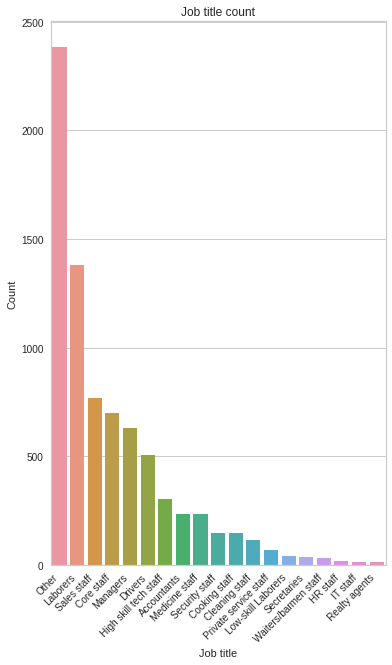

In [ ]:
create_bar_plot(cc_train_copy,'Job title')

The most prolific Job title is laborers by far (Others - N/A)

# ***Employment Status***

In [ ]:
gen_info_feat(cc_train_copy,'Employment status')

Description:
count        7767
unique          5
top       Working
freq         3947
Name: Employment status, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                      Count  Frequency (%)
Working                3947          50.82
Commercial associate   1847          23.78
Pensioner              1382          17.79
State servant           589           7.58
Student                   2           0.03


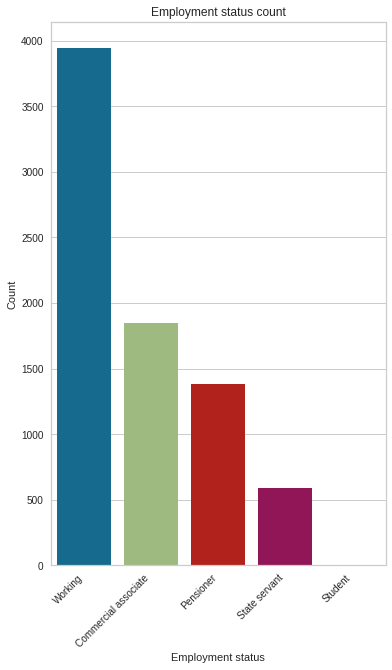

In [ ]:
create_bar_plot(cc_train_copy,'Employment status')

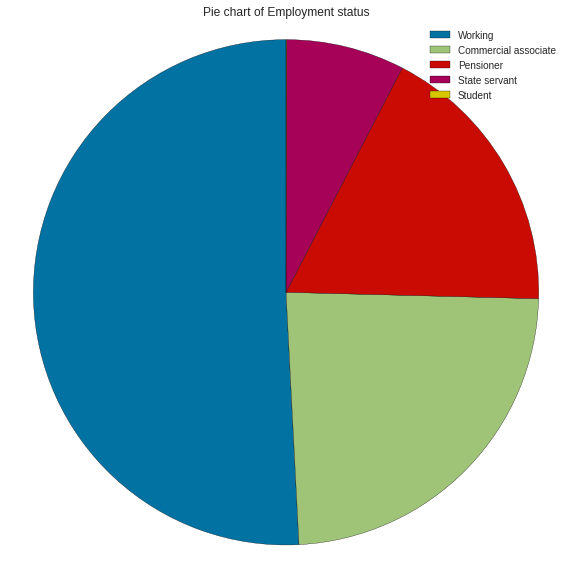

In [ ]:
create_pie_plot(cc_train_copy,'Employment status')

Most applicants are employed

# ***Education Level***

In [ ]:
gen_info_feat(cc_train_copy,'Education level')

Description:
count                              7767
unique                                5
top       Secondary / secondary special
freq                               5400
Name: Education level, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
                               Count  Frequency (%)
Secondary / secondary special   5400          69.52
Higher education                1969          25.35
Incomplete higher                297           3.82
Lower secondary                   95           1.22
Academic degree                    6           0.08


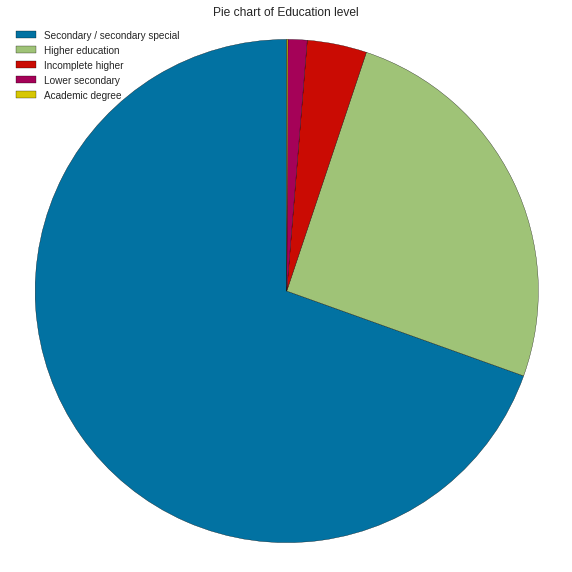

In [ ]:
create_pie_plot(cc_train_copy,'Education level')

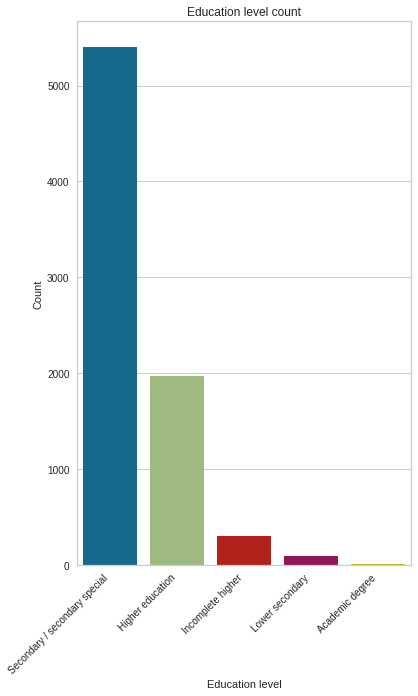

In [ ]:
create_bar_plot(cc_train_copy,'Education level')

The majority of applicants have completed their secondary degree, ¼ completed their higher education

In [ ]:
gen_info_feat(cc_train_copy,'Employment length')

Description:
count   6397.00
mean       6.82
std        6.30
min        0.18
25%        2.36
50%        4.94
75%        9.16
max       43.02
Name: Employment length, dtype: float64
**************************************************
Object type:int64


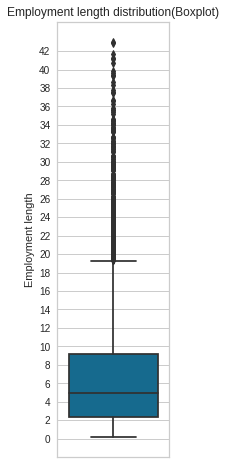

In [ ]:
create_box_plot(cc_train_copy,'Employment length')

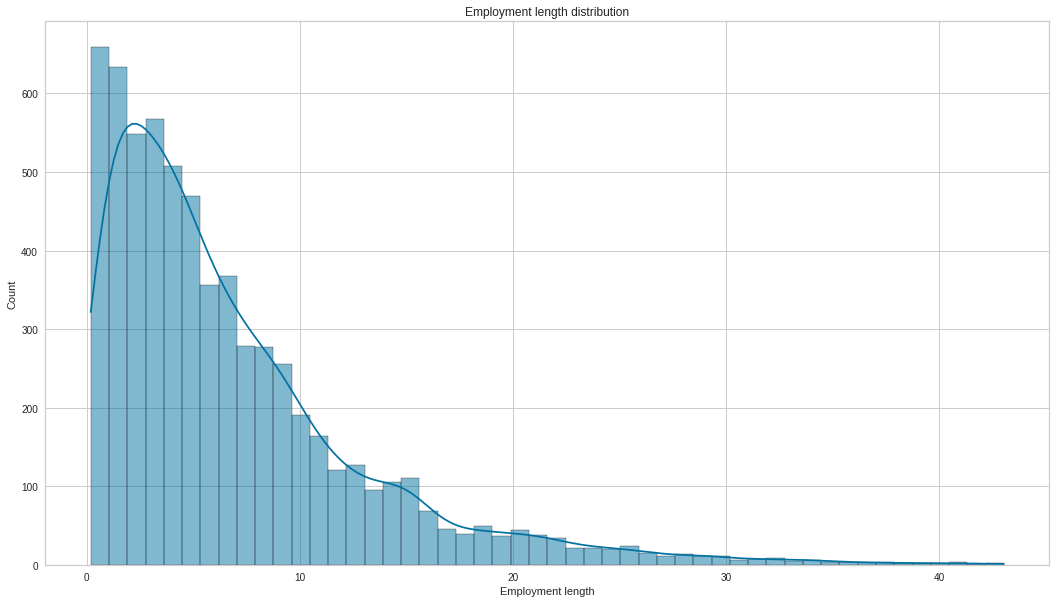

In [ ]:
create_hist_plot(cc_train_copy,'Employment length')

Is high risk
0   6.84
1   5.95
Name: Employment length, dtype: float64


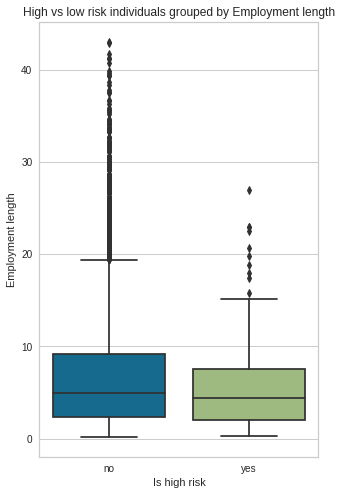

In [ ]:
# distribution of employment length for high vs low risk applicants
# Here 0 means No and 1 means Yes
low_high_risk_box_plot(cc_train_copy,'Employment length')

Interpretation:

Most of applicant have been working for 7 years

We have quite a number of outliers who have been working for more than 20 years+

The employment length is positively skewed

Those who are high risk have a low employment length of 6 versus 7 years for the low risk

# ***Has a car***

In [ ]:
gen_info_feat(cc_train_copy,'Has a car')

Description:
count     7767
unique       2
top          N
freq      4885
Name: Has a car, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
N   4885          62.89
Y   2882          37.11


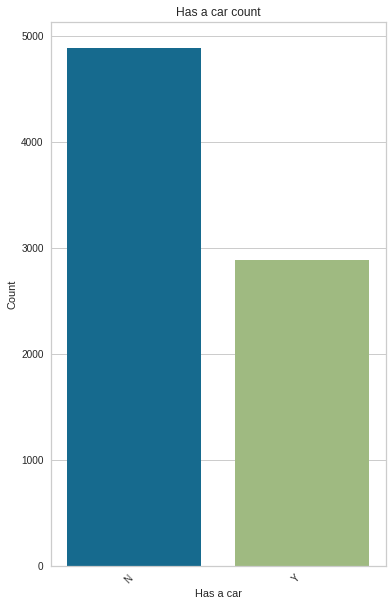

In [ ]:
create_bar_plot(cc_train_copy,'Has a car')

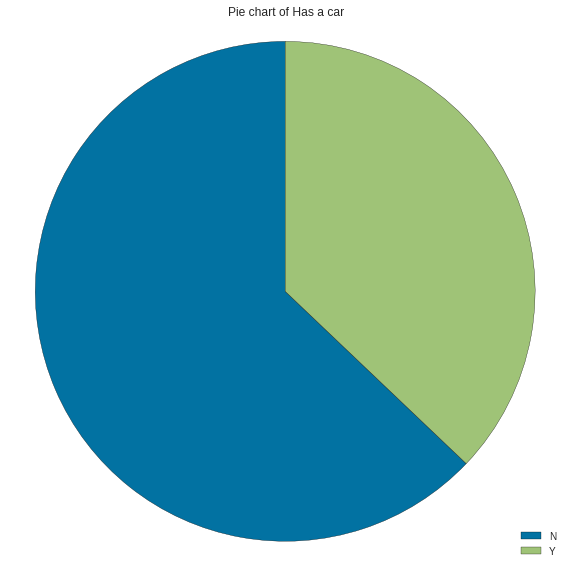

In [ ]:
create_pie_plot(cc_train_copy,'Has a car')

Most applicant don’t own a car



# ***Has a Property***

In [ ]:
gen_info_feat(cc_train_copy,'Has a property')

Description:
count     7767
unique       2
top          Y
freq      5220
Name: Has a property, dtype: object
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
Y   5220          67.21
N   2547          32.79


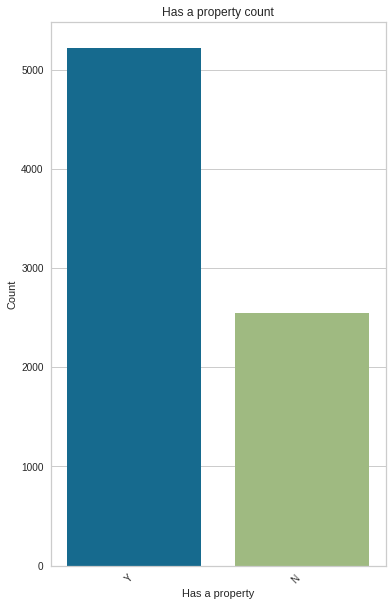

In [ ]:
create_bar_plot(cc_train_copy,'Has a property')

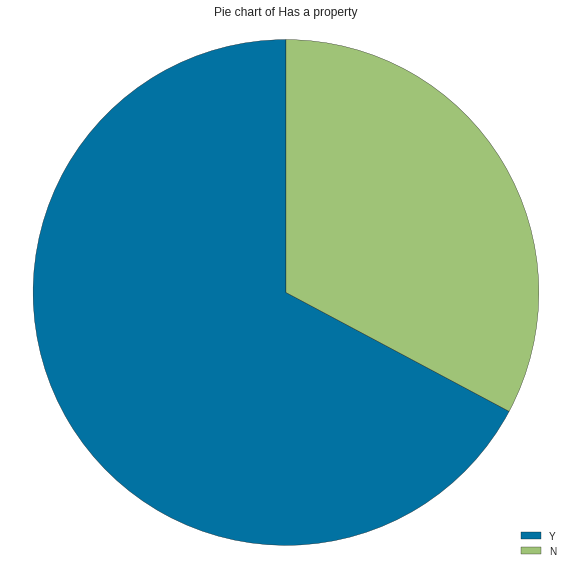

In [ ]:
create_pie_plot(cc_train_copy,'Has a property')

Interpretation:

Most applicants own a property

# ***Has a Work Phone***

In [ ]:
gen_info_feat(cc_train_copy,'Has a work phone')

Description:
count   7767.00
mean       0.22
std        0.41
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: Has a work phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0   6060          78.02
1   1707          21.98


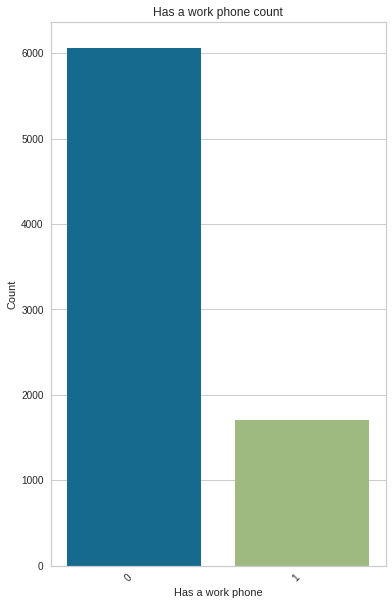

In [ ]:
create_bar_plot(cc_train_copy,'Has a work phone')

More than ¾ of applicants don’t have a work phone
Note: Here 0 is no and 1 is yes

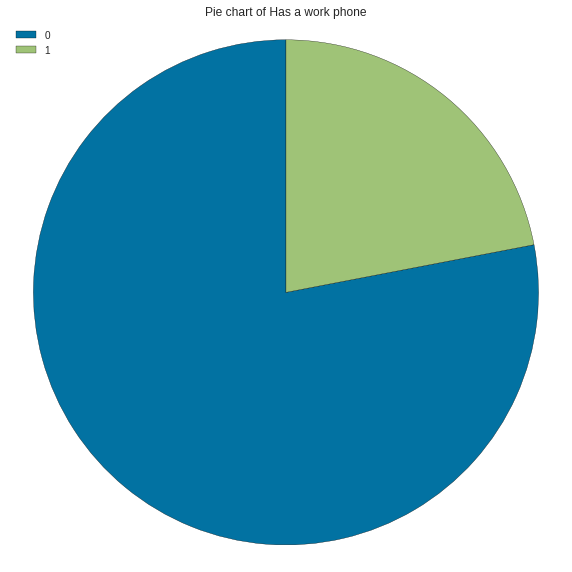

In [ ]:
create_pie_plot(cc_train_copy,'Has a work phone')

Interpretation:

More than ¾ of applicants don’t have a work phone

# ***Has a Phone***

In [ ]:
gen_info_feat(cc_train_copy,'Has a phone')

Description:
count   7767.00
mean       0.29
std        0.45
min        0.00
25%        0.00
50%        0.00
75%        1.00
max        1.00
Name: Has a phone, dtype: float64
**************************************************
Object type:
int64
**************************************************
Value count:
   Count  Frequency (%)
0   5517          71.03
1   2250          28.97


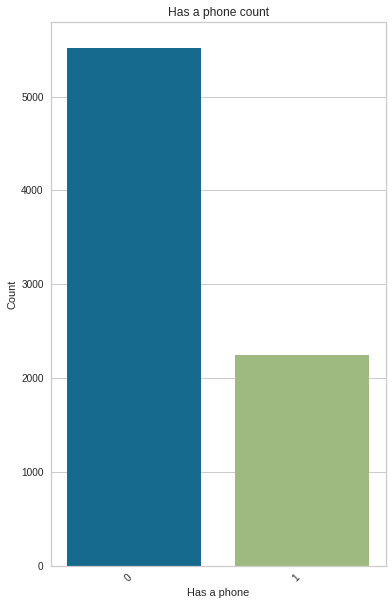

In [ ]:
create_bar_plot(cc_train_copy,'Has a phone')

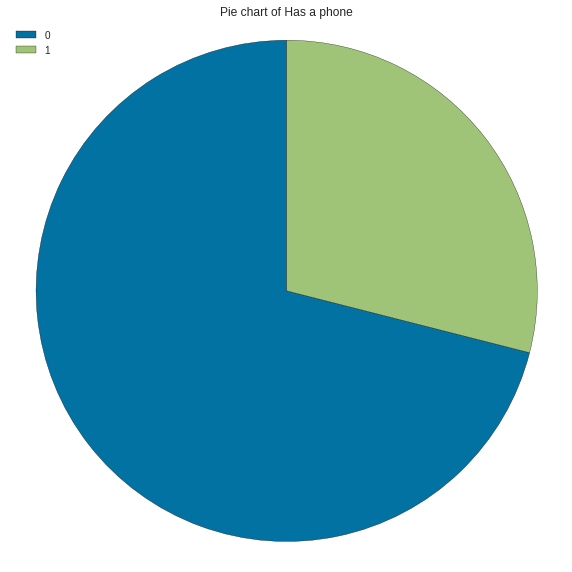

In [ ]:
create_pie_plot(cc_train_copy,'Has a phone')

Most applicants don’t have a phone (probably a home phone)

Note: Here 0 is no and 1 is yes

# ***Account Age***

In [ ]:
gen_info_feat(cc_train_copy,'Account age')

Description:
count   7767.00
mean      27.35
std       16.60
min        0.00
25%       13.00
50%       26.00
75%       41.00
max       60.00
Name: Account age, dtype: float64
**************************************************
Object type:float64


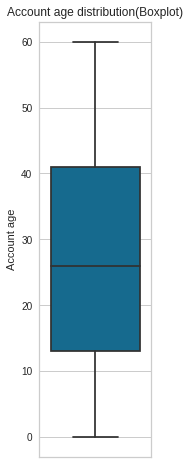

In [ ]:
create_box_plot(cc_train_copy,'Account age')

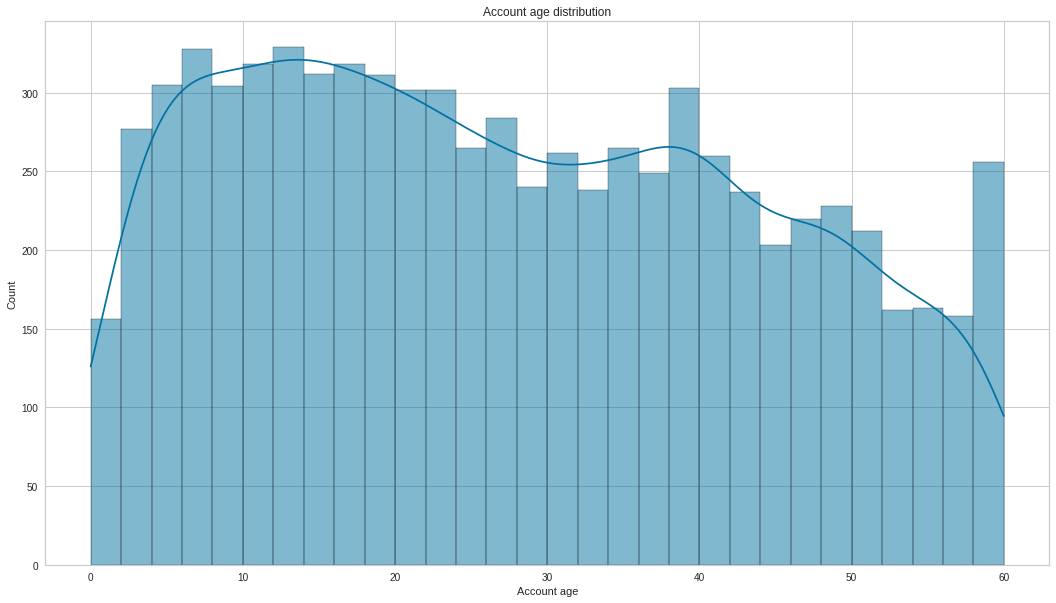

In [ ]:
create_hist_plot(cc_train_copy,'Account age', the_bins=30)

Is high risk
0   27.18
1   35.19
Name: Account age, dtype: float64


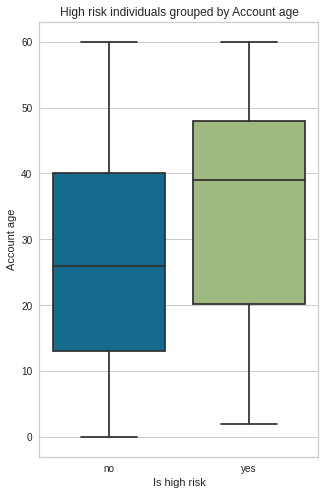

In [ ]:
low_high_risk_box_plot(cc_train_copy,'Account age')

Most accounts are 26 months old

Account age is not normally distributed, it is positively skewed

The accounts that have been flagged as high risk are on average 35 months old vs 27 months old for old account

# ***Is High Risk***

In [ ]:
gen_info_feat(cc_train_copy,'Is high risk')

Description:
count     7767
unique       2
top          0
freq      7605
Name: Is high risk, dtype: int64
**************************************************
Object type:
object
**************************************************
Value count:
   Count  Frequency (%)
0   7605          97.91
1    162           2.09


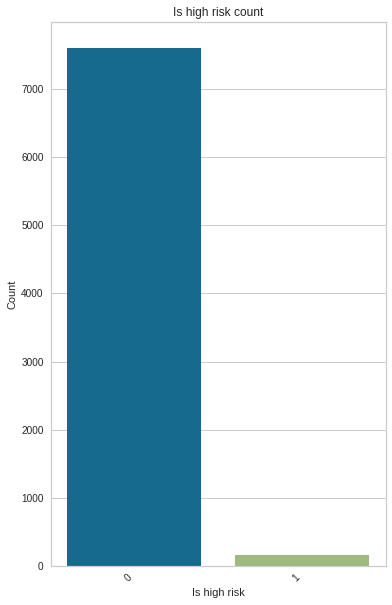

In [ ]:
create_bar_plot(cc_train_copy,'Is high risk')

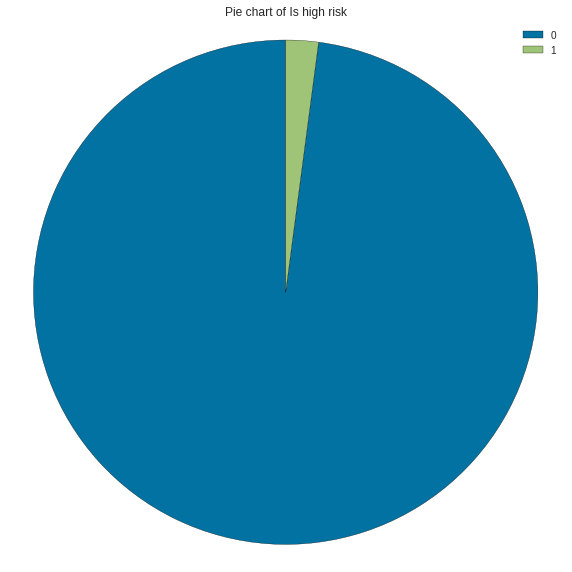

In [ ]:
create_pie_plot(cc_train_copy,'Is high risk')

A vast majority of applicants are low risk applicants.
We have a very imbalance data.

Note: Here 0 is no and 1 is yes

# ***Numerical vs numerical features***

***Scatter plots***

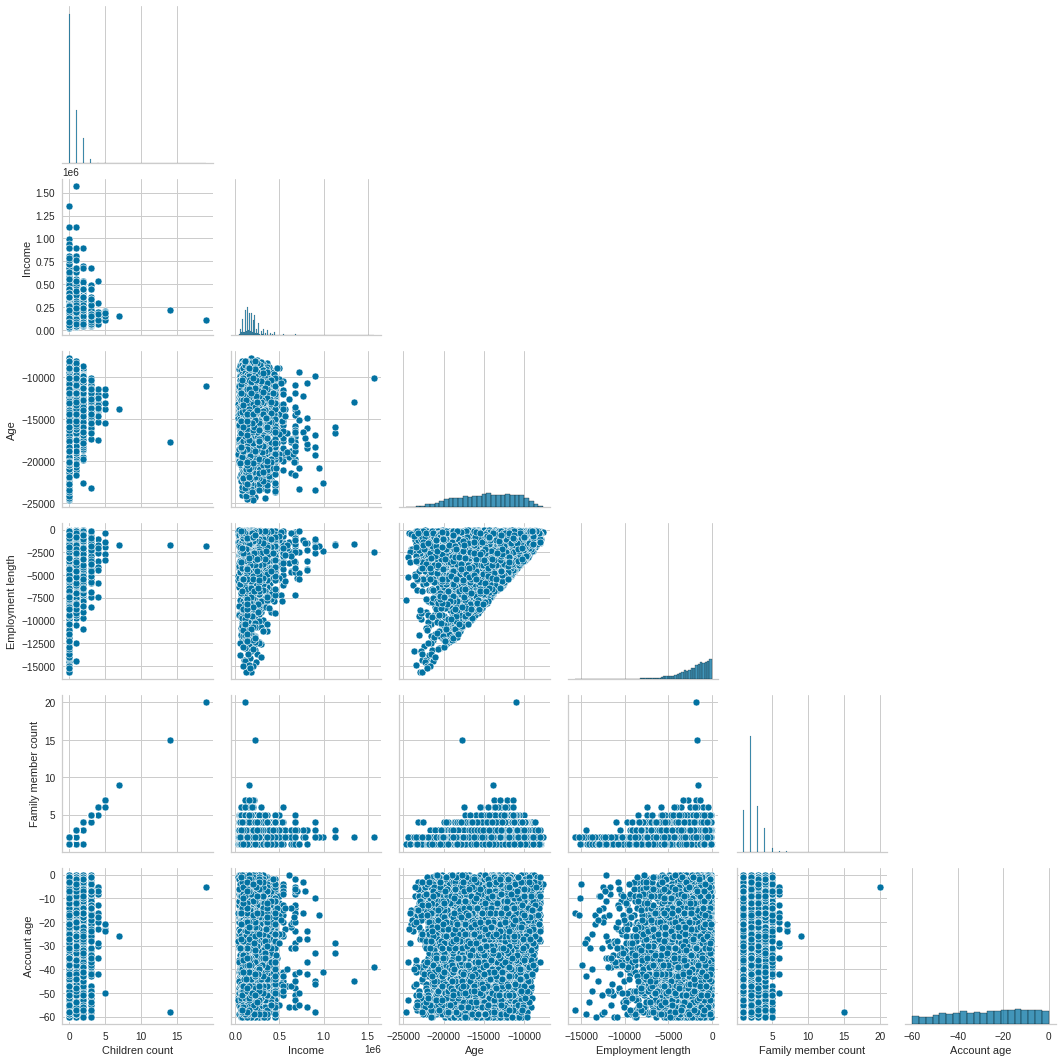

In [ ]:
sns.pairplot(cc_train_copy[cc_train_copy['Employment length'] < 0].drop(['ID', 'Has a work phone', 'Has a phone', 'Has an email','Is high risk'],axis=1),corner=True)
plt.show()

Interpretation:

We can see a positive linear correlation between the family member and the children count. This makes sense, the more the children someone have, the larger the family member count. This is a multicollinearity problem. Meaning that the features are highly correlated. We will need to drop one of them.

Another interesting trend is the Employment length and age. This also makes sense, the longer the employee has been working, the older they are.

***Family member count vs children count ***

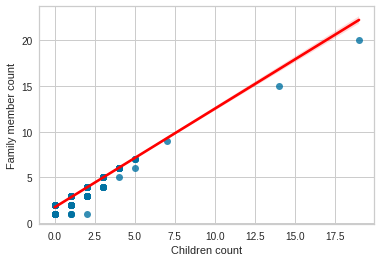

In [ ]:
sns.regplot(x='Children count',y='Family member count',data=cc_train_copy,line_kws={'color': 'red'})
plt.show()

Interpretation:

The more children a person has, the larger the family member count.

***Account age vs age***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


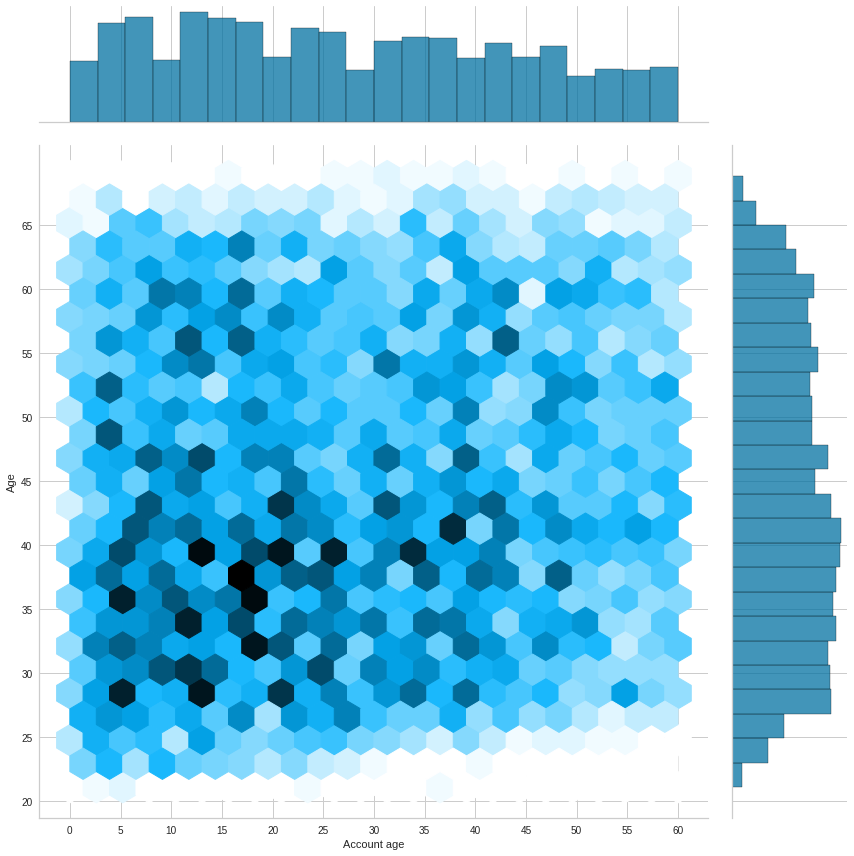

In [ ]:
y_age = np.abs(cc_train_copy['Age'])/365.25
sns.jointplot(np.abs(cc_train_copy['Account age']),y_age, kind="hex", height=12)
plt.yticks(np.arange(20, y_age.max(), 5))
plt.xticks(np.arange(0, 65, 5))
plt.ylabel('Age')
plt.show()

Most of the applicants are between 20 and 45 years old and have an account that is less than 25 months old.

***Employment length vs age ***

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


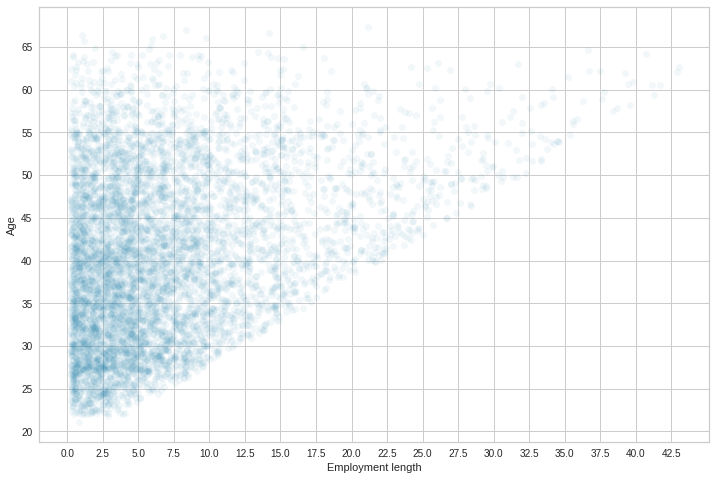

In [ ]:
x_employ_length = np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length'])/365.25
fig, ax = plt.subplots(figsize=(12,8))
sns.scatterplot(x_employ_length,y_age,alpha=.05)
# change the frequency of the x-axis and y-axis labels
plt.xticks(np.arange(0, x_employ_length.max(), 2.5))
plt.yticks(np.arange(20, y_age.max(), 5))
plt.show()

Interpretation:

This scatterplot shows that the age of the applicants is correlated with the length of the employment. The reason why it is shaped like a reversed triangle, it is because the age of the applicants increase with the length of the employment. You can't have an employment length > than the age.

***Correlation analysis***

In [ ]:
# change the datatype of target feature to int
is_high_risk_int = cc_train_copy['Is high risk'].astype('int32')

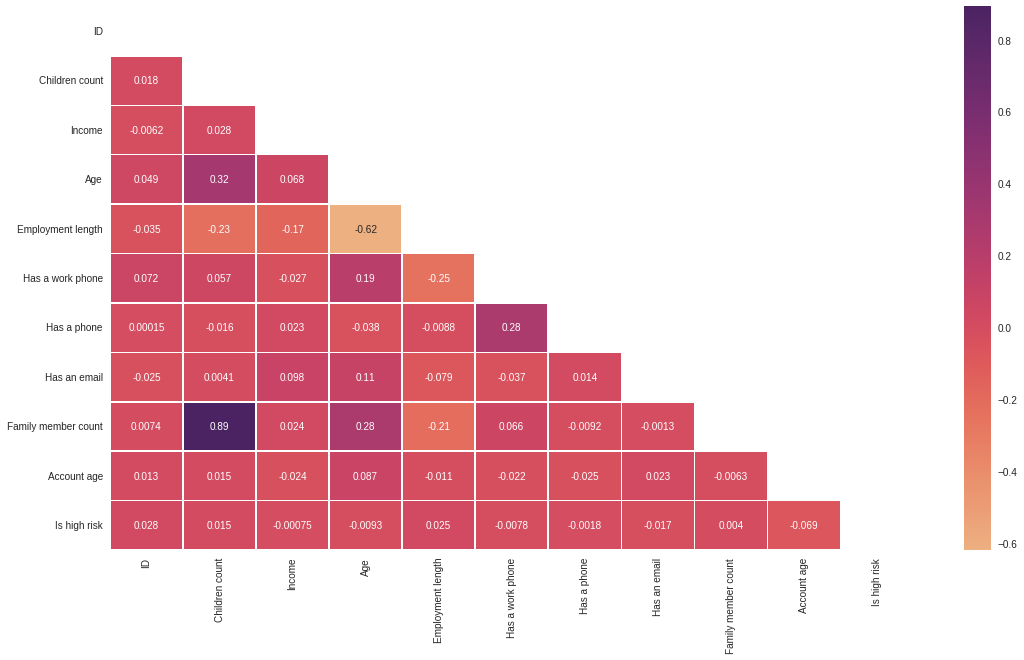

In [ ]:
# correlation analysis with heatmap, after dropping the has a mobile phone with the target feature as int
cc_train_copy_corr_no_mobile = pd.concat([cc_train_copy.drop(['Is high risk'], axis=1),is_high_risk_int],axis=1).corr()
# Get the lower triangle of the correlation matrix
# Generate a mask for the upper triangle
mask = np.zeros_like(cc_train_copy_corr_no_mobile, dtype='bool')
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(18,10))
# seaborn heatmap
sns.heatmap(cc_train_copy_corr_no_mobile, annot=True, cmap='flare',mask=mask, linewidths=.5)
# plot the heatmap
plt.show()

There is no feature that is correlated with the target feature

Family member count is highly correlated with children count as previously discussed

Age has some positive correlation with the family member count and children count. The older a person is, the most likely he/she will have a larger family.

Another positive correlation is having a phone and having a work phone.

The final positive correlation is between the age and work phone. The younger someone is the less likely he/she will have a work phone.

We also have a negative correlation between the employment length and the age as previously seen.

# ***Numerical vs categorical features***

***Age vs the rest of categorical features***

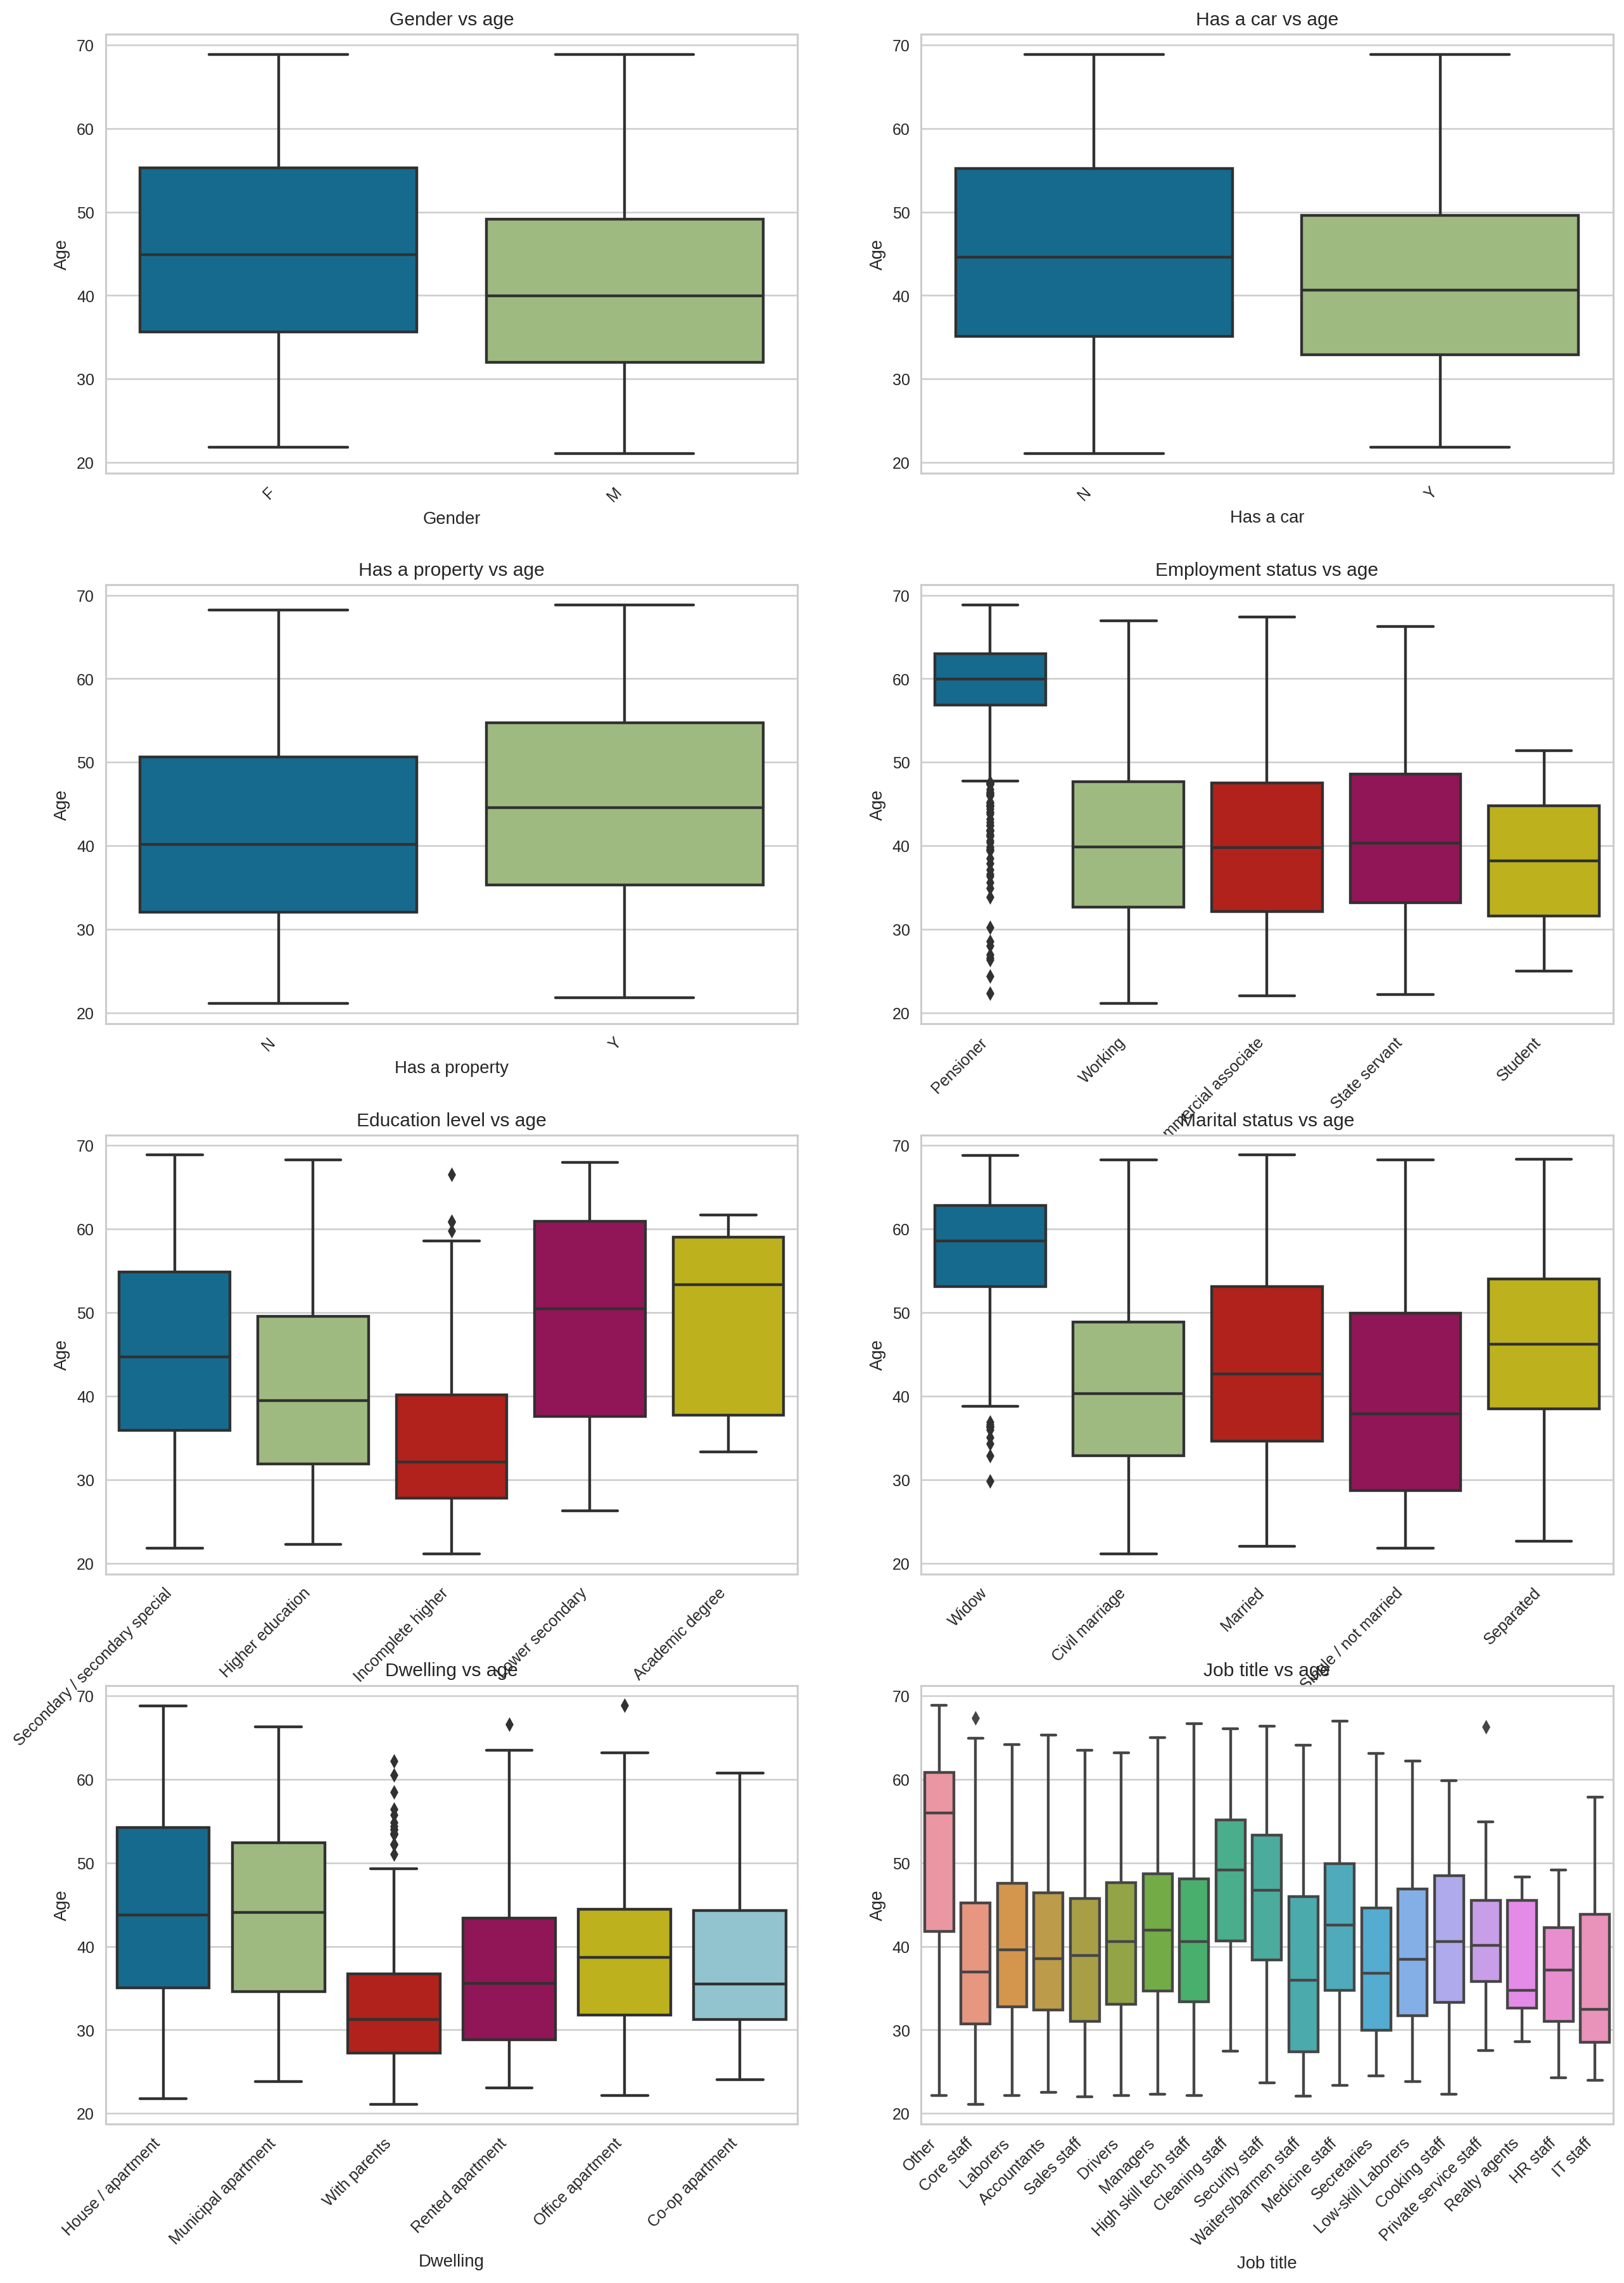

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)
cat_features = ['Gender', 'Has a car', 'Has a property', 'Employment status', 'Education level', 'Marital status', 'Dwelling', 'Job title']
for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy['Age'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs age")
            plt.sca(axes[row_count,feat_count])
            plt.xticks(rotation=45,ha='right')
            plt.ylabel('Age')
            cat_ft_count += 1
    break

Interpretations:

Female applicants are older than their male counterpart.

Those who don't own a car tend to be older.

Those who own a property tend to be older than those who don't.

Of course, the pensioners are older that those who are working (We also see that some have pensioned at a young age, those are outliers).

It is also interesting to see that those who hold an academic degree are younger in general than the other groups.

Obviously, the widows tend to be much older. We also see some outliers in their 30's as well.

With no surprise, those who live with parent tend to be younger. We also see some outlier as well.

Lastly, who work as cleaning staff tend to be older while those who work in IT tend to be younger.

***Income vs the rest of categorical features***

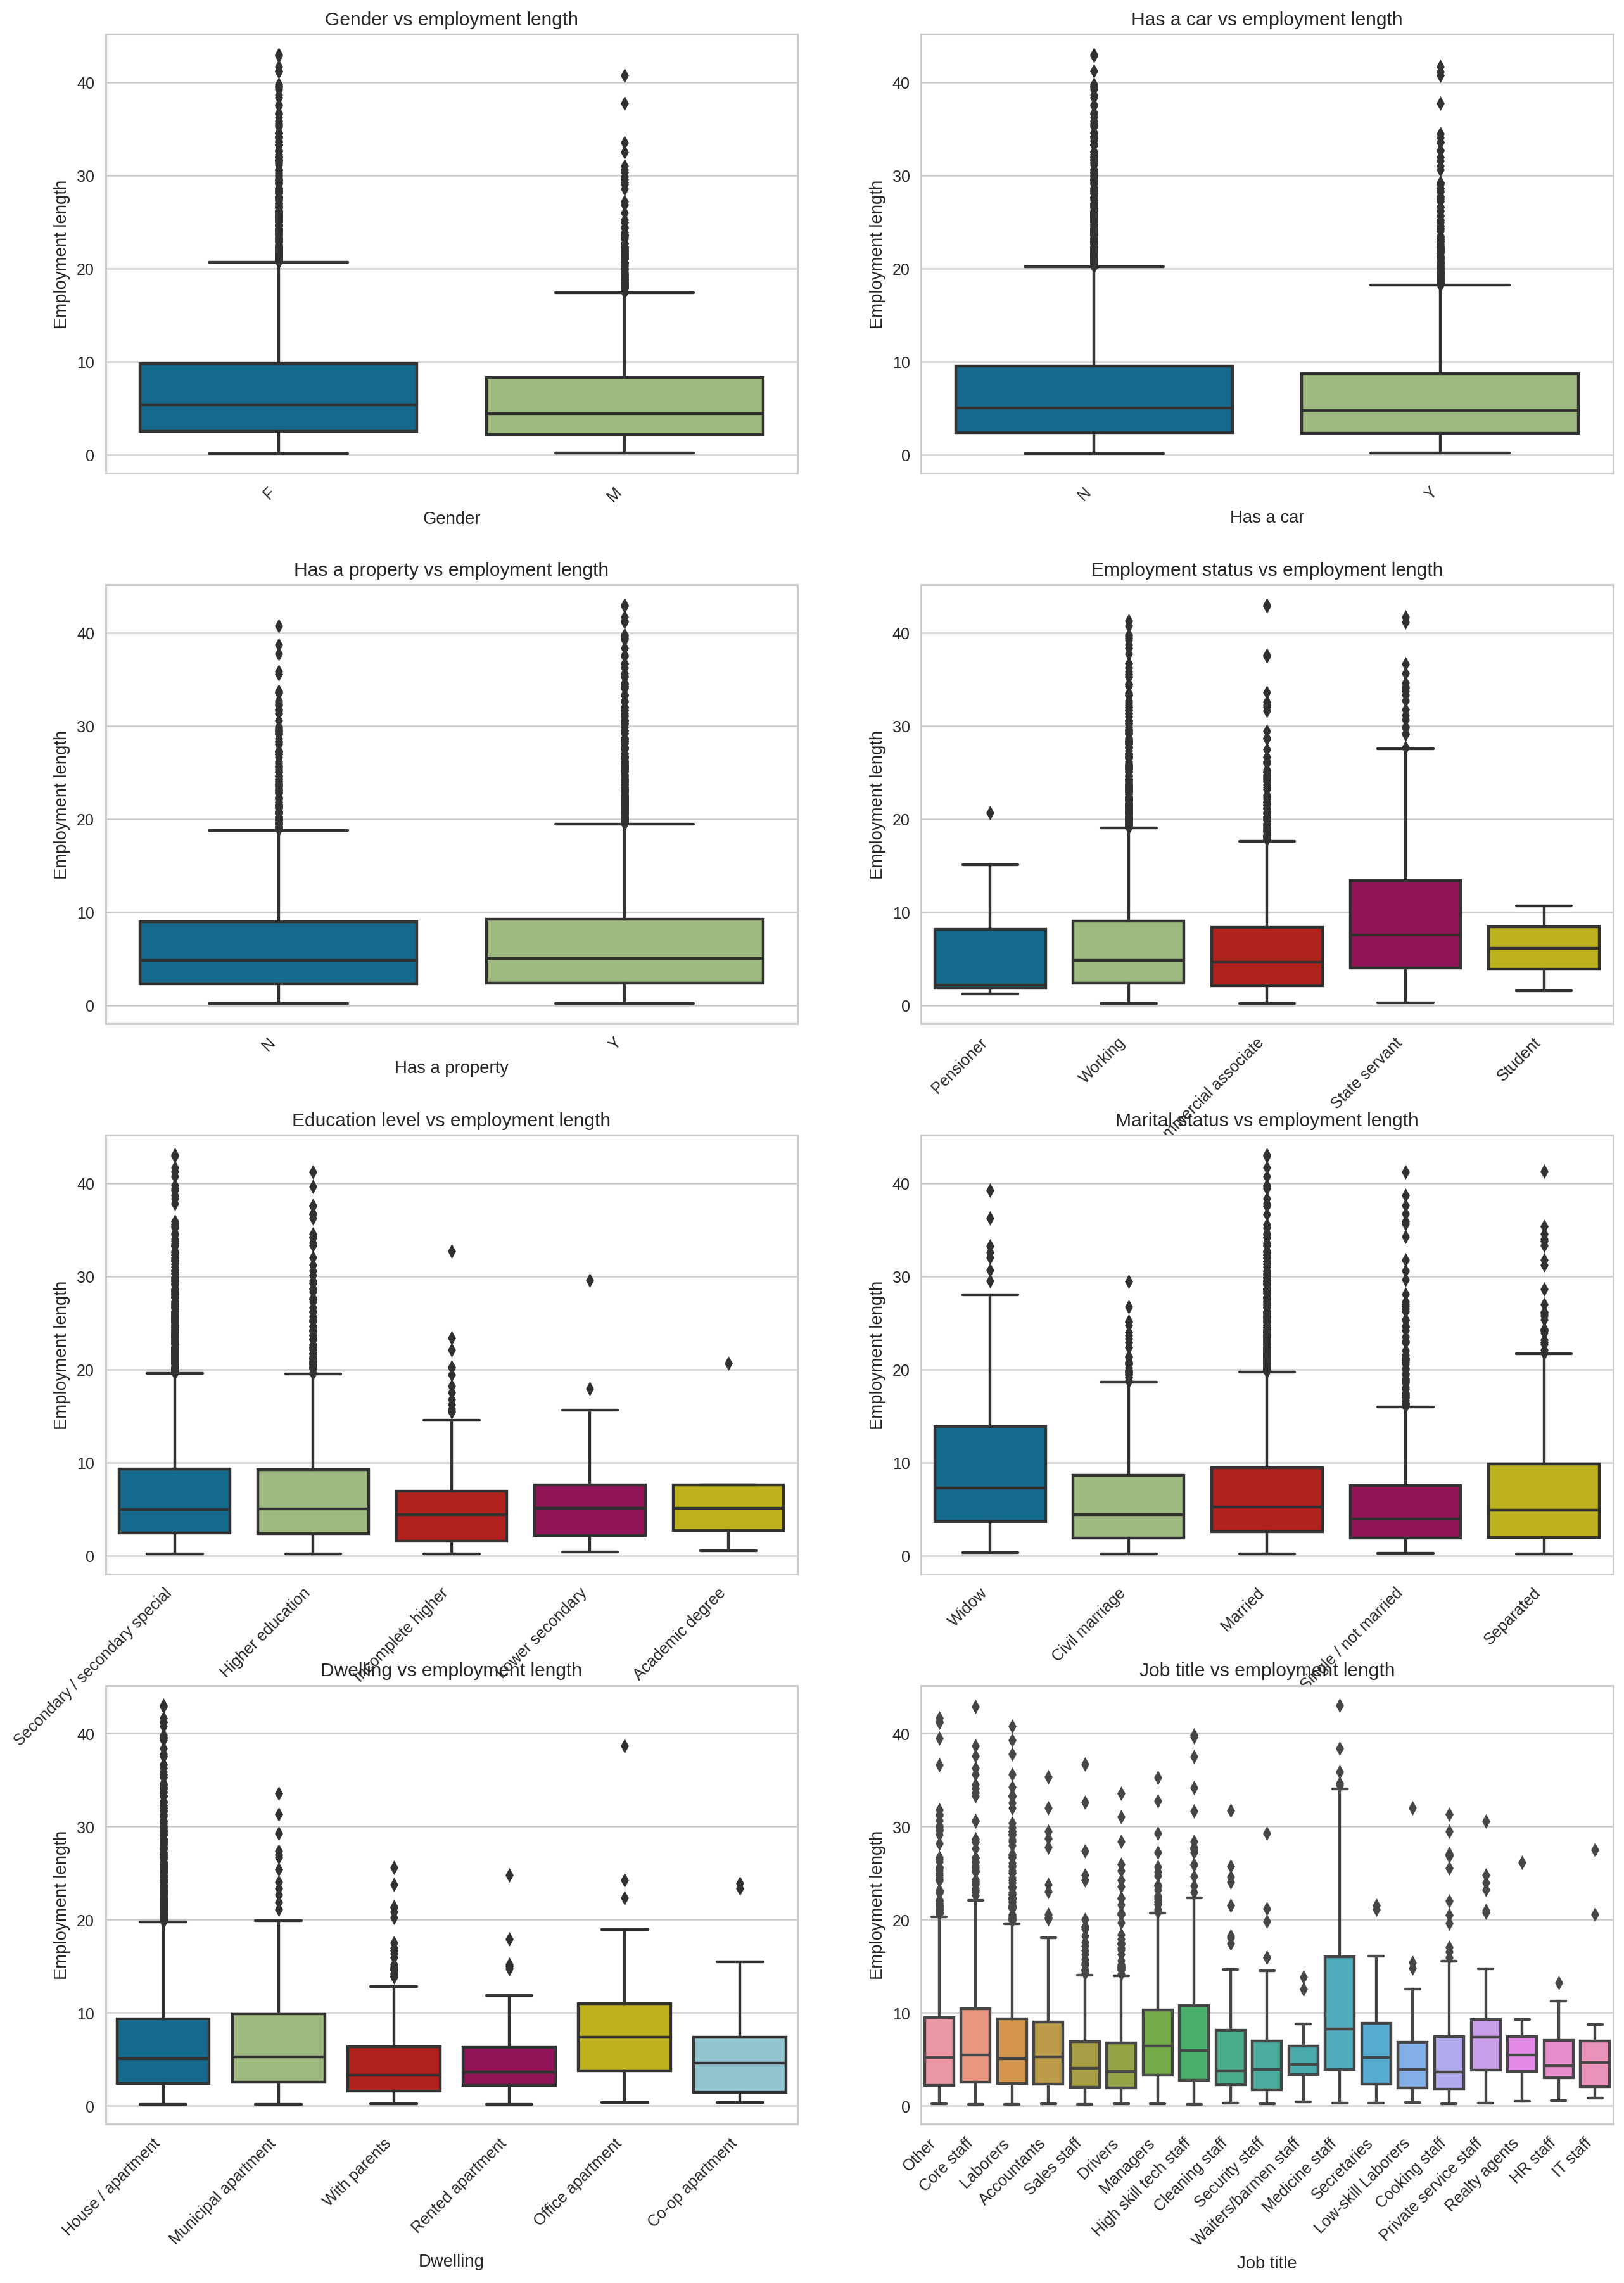

In [ ]:
fig, axes = plt.subplots(4,2,figsize=(15,20),dpi=180)
fig.tight_layout(pad=5.0)

for cat_ft_count, ax in enumerate(axes):
    for row_count in range(4):
        for feat_count in range(2):
            sns.boxplot(ax=axes[row_count,feat_count],x=cc_train_copy[cat_features[cat_ft_count]],y=np.abs(cc_train_copy[cc_train_copy['Employment length'] < 0]['Employment length'])/365.25)
            axes[row_count,feat_count].set_title(cat_features[cat_ft_count] + " vs employment length")
            plt.sca(axes[row_count,feat_count])
            plt.ylabel('Employment length')
            plt.xticks(rotation=45,ha='right')
            cat_ft_count += 1
    break

Interpretation:

State employed applicant tend to have been employed longer than the rest.
Those who work in the medical field, have been employed longer than the rest.

Working on the next part of the code.

In [ ]:
def imputeWithMode(df):
    """ 
    Going through each columns and checking the type is object
    if it is object, impute it with most frequent value
    """
    for col in df:
        if df[col].dtypes == 'object':
            df[col] = df[col].fillna(df[col].mode().iloc[0])
imputeWithMode(cc_data_full_data)

In [ ]:
cc_data_full_data.isnull().sum()

ID                     0
Gender                 0
Has a car              0
Has a property         0
Children count         0
Income                 0
Employment status      0
Education level        0
Marital status         0
Dwelling               0
Age                    0
Employment length      0
Has a work phone       0
Has a phone            0
Has an email           0
Job title              0
Family member count    0
Account age            0
Is high risk           0
dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
# # Looping for each object type column
#Using label encoder to convert into numeric types
for col in cc_data_full_data:
    if cc_data_full_data[col].dtypes=='object':
        cc_data_full_data[col]=le.fit_transform(cc_data_full_data[col])

In [ ]:
cc_data_full_data.tail(15)

,ID,Gender,Has a car,Has a property,Children count,Income,Employment status,Education level,Marital status,Dwelling,Age,Employment length,Has a work phone,Has a phone,Has an email,Job title,Family member count,Account age,Is high risk
9694,5126012,0,0,0,0,270000.00,2,4,1,1,-20103,-1444,1,1,0,18,2.00,-31.00,1
9695,5135483,1,0,1,0,135000.00,2,1,3,2,-10660,-1935,0,0,0,3,1.00,-9.00,1
9696,5136014,1,0,0,1,112500.00,4,4,0,1,-13080,-1327,0,0,0,6,3.00,-27.00,1
9697,5142456,0,0,0,0,67500.00,0,1,2,1,-18952,-499,0,1,0,3,1.00,-5.00,1
9698,5142972,1,0,0,1,180000.00,4,4,3,1,-10656,-926,1,1,0,8,3.00,-34.00,1
9699,5142973,1,0,0,1,180000.00,4,4,1,1,-10656,-926,1,1,0,8,1.00,-18.00,1
9700,5143578,1,1,0,0,157500.00,4,2,3,5,-9124,-960,1,0,0,4,2.00,-14.00,1
9701,5145690,0,0,1,0,306000.00,1,1,1,1,-21590,365243,0,0,0,12,2.00,-17.00,1
9702,5145760,0,1,0,0,135000.00,4,1,1,1,-15468,-4834,0,0,1,12,2.00,-10.00,1
9703,5146078,0,0,1,1,108000.00,4,4,3,1,-12723,-1132,1,1,0,15,1.00,-48.00,1


In [ ]:
from sklearn.model_selection import train_test_split
cc_data_full_data = cc_data_full_data.drop(['ID'], axis=1)
cc_data_full_data = cc_data_full_data.values

In [ ]:
# Creating new variable to input features and labels
X,y = cc_data_full_data[:,0:15] , cc_data_full_data[:,15]

# Spliting the data into training and testing sets
X_train, X_test, y_train, Y_test = train_test_split(X,
                                y,
                                test_size=0.2,
                                random_state=123)

In [ ]:
# Import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Scaling X_train and X_test
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX_train = scaler.fit_transform(X_train)
rescaledX_test = scaler.transform(X_test)

In [ ]:
rescaledX = scaler.transform(X)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
rf = RandomForestClassifier(n_estimators=500)
rf.fit(rescaledX_train, y_train)
y_pred = rf.predict(rescaledX_test)
print("Random Forest classifier has accuracy of: ", rf.score(rescaledX_test, Y_test))
# Evaluate the confusion_matrix
confusion_matrix(Y_test, y_pred)

Random Forest classifier has accuracy of:  0.9897013388259527


array([[414,   1,   1,   1,   0,   0,   0,   0,   0],
       [  5, 994,   0,   0,   0,   0,   0,   0,   0],
       [  1,   0, 335,   0,   0,   0,   0,   0,   0],
       [  1,   1,   1, 156,   0,   0,   0,   0,   0],
       [  0,   0,   0,   2,  23,   0,   0,   0,   0],
       [  0,   0,   0,   1,   2,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0]])

Feature ranking:
1. feature 3 (0.464527)
2. feature 7 (0.364396)
3. feature 9 (0.060140)
4. feature 10 (0.032207)
5. feature 4 (0.021754)
6. feature 14 (0.015061)
7. feature 5 (0.006941)
8. feature 8 (0.005495)
9. feature 1 (0.005308)
10. feature 6 (0.005262)
11. feature 0 (0.004862)
12. feature 2 (0.004204)
13. feature 12 (0.003959)
14. feature 11 (0.003536)
15. feature 13 (0.002347)


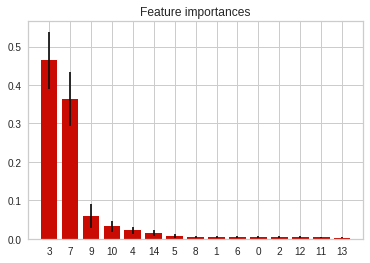

In [ ]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

# ***Findings from the EDA***

Typical profile of an applicant is: a Female in her early 40’s, married with a partner and no child. She has been employed for 5 years with a salary of 157500. She has completed her secondary education. She does not own a car but owns a property (a house/ apartment). Her account is 26 months old.

Age and income do not have any effects on the target variable

Those who are flagged as bad client, tend to have a shorter employment length and older accounts. They also constitute less than 2% of total applicants.

Most applicants are 20 to 45 years old and have an account that is 25 months old or less.

# ***Few Questions and Answers related to EDA***

Question: Is income a good predictor of high or low risk?

Answer: No, mean for both high and low risks are relatively the same (~200K HH income); high risk applicants have a slightly higher standard deviation.

Question: Does employment length positively correlate with approval status? If an employee works at a firm at a long time, it might suggest income stability and potentially better credit ratings

Answer: No, minimal correlation at 0.023

Question: Does good debt status positively correlate with approval or high risk status? If an applicant is able to keep their credit payment history in good standings, it would theoretically improve their credit ratings which aid them in the approval process. 

Answer: No, minimal correlation at 0.088 (status) and 0.039 (high risk) 

Question: Does having a property positively correlate with approval of credit cards? Purely from a financial perspective in banking, if a loan applicant has a property, that means the bank can lend a collateralized loan that is backed by the property. In a similar sense, owning a property should return a positive correlation with the approval rate of credit cards. 

Answer: No, looking at the analysis, we found a negative correlation of 0.00024 between credit card approval rate and the ownership of property. 

Question: Would age matter in credit approval status?

Answer: No, the correlation between age and approval status is considerably small at 0.019. 

Question: Does the length of account positively correlate with credit card approval status?

Answer: No, the correlation between account length and approval status is considerably small at negative 0.049.

Question: What is a good predictor of a “declined” credit card status?

Answer: It looks like there is a moderate negative correlation between bad debt and approval status at -0.42, which makes sense. 

Questions: Are there higher risks associated with age groups? Potentially higher risk with younger applicants? 

Answer, not really, both high or low risks have mean age around 40~41, with high risk portfolio having a higher standard deviation





***Simple demographic questions and answers:*** 

How many unique applicants are there: 19,396

What is the mean annual income: $194,683

What is the average typical household size: 2.3 (most likely a couple with a kid), which makes sense because almost 70% of the applicants are married

What is the average age of applicants: 44

What is the average employment length: 7.68 years

What is the gender split? 65% female, 35% male

What does the age distribution look like? Almost normal distribution, a little right skewed 

